# [DM 2025/26] Phoneme Classification

💡The purpose of this project is to address the problem of the Phoneme Classification as it's proposed in one of the must-know datasets in Machine Learning: <a href="https://www.openml.org/search?type=data&sort=runs&id=1489&status=active">phoneme</a>.

The aim of this dataset is to distinguish between nasal and oral vowels. There are thus two different classes:

- Class 0 : Nasals
- Class 1 : Orals

🗣 This dataset contains vowels coming from 1809 isolated syllables (for example: pa, ta, pan,...). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. Each harmonic is signed: positive when it corresponds to a local maximum of the spectrum and negative otherwise.

Three observation moments have been kept for each vowel to obtain 5427 different instances:

- the observation corresponding to the maximum total energy Ene.

- the observations taken 8 msec before and 8 msec after the observation corresponding to this maximum total energy.

From these 5427 initial values, 23 instances for which the amplitude of the 5 first harmonics was zero were removed, leading to the 5404 instances of the present database. The patterns are presented in a random order.

As first step, we import the necessary libraries for the project, we divided them according to their utility, these include:
- Machine Learning/Data Mining, 
- Data Visualization, 
- Preprocessing
- General purpose utilities

In [1]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities
import csv
import json
import os
from typing import Any

## Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.preprocessing import MinMaxScaler, Binarizer
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# cross-validation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone

# supress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



c:\Users\fraca\Desktop\Universita\Applied AI\DM\phoneme_classification\DM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Dataset Analysis

We then download the dataset and extract some basic information like the feature names and the unique value frequency of the classses; to have a basic idea of the structure of the data, we also display the first rows of the dataset.

In [30]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data
labels = dataset.target

# Taking feature names and label names
feature_names = dataset.feature_names
feature_names

['V1', 'V2', 'V3', 'V4', 'V5']

The dataset has 5 features as specified in the description, they are all real numbers, so they can be considered as belonging to the **ratio** category.

In [4]:
data.head()

V1        V2        V3        V4        V5
0  0.489927 -0.451528 -1.047990 -0.598693 -0.020418
1 -0.641265  0.109245  0.292130 -0.916804  0.240223
2  0.870593 -0.459862  0.578159  0.806634  0.835248
3 -0.628439 -0.316284  1.934295 -1.427099 -0.136583
4 -0.596399  0.015938  2.043206 -1.688448 -0.948127

Counting the unique values of the classes, we discover that the class ratio is 70% - 30%, this suggests high imbalancing so, in the following analysis will be foundamental to considerate balancing strategies to mitigate the problem.

In [32]:
labels.value_counts() / labels.value_counts().sum()


Class
1    0.706514
2    0.293486
Name: count, dtype: float64

With the `describe()` method we can visualize a dataframe with all the basic statistics of the dataset. In particular we observe that all the features have mean = 0 (with reasonable approximation) and standard deviation = 1 meaning that they are **already standardized** and don't need any additional scaling.

In [6]:
# Extracting statistics on data
data.describe()

V1            V2            V3            V4            V5
count  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03
mean   3.330866e-09  5.551443e-09  6.106588e-09 -9.437454e-09 -6.698742e-08
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -2.933743e+00 -3.038709e+00 -2.795869e+00 -2.485340e+00 -2.367461e+00
25%   -6.697555e-01 -7.790800e-01 -9.505788e-01 -7.583255e-01 -5.405418e-01
50%   -3.801605e-01 -2.150985e-01 -3.861800e-02 -1.422555e-01 -2.127475e-01
75%    3.149040e-01  7.136990e-01  7.771393e-01  6.759035e-01  2.045420e-01
max    3.828575e+00  3.664763e+00  2.630868e+00  3.046948e+00  4.586666e+00

To better visualize the inner structure of the dataset we render 3 plots:
- A group of **boxplots** each representing the distribution of a feature, as they are standard scaled we do not expect any relevant difference on the position or on the variability, however some variation can be observed.
- A **barplot** showing the class distribution; it highlights the imbalance between class 1 and 2
- A **parallel coordinates plot** that gives us more insight on the structure of the features. The class imbalance is also visible from this perspective as the blue lines almost cover the orange ones.

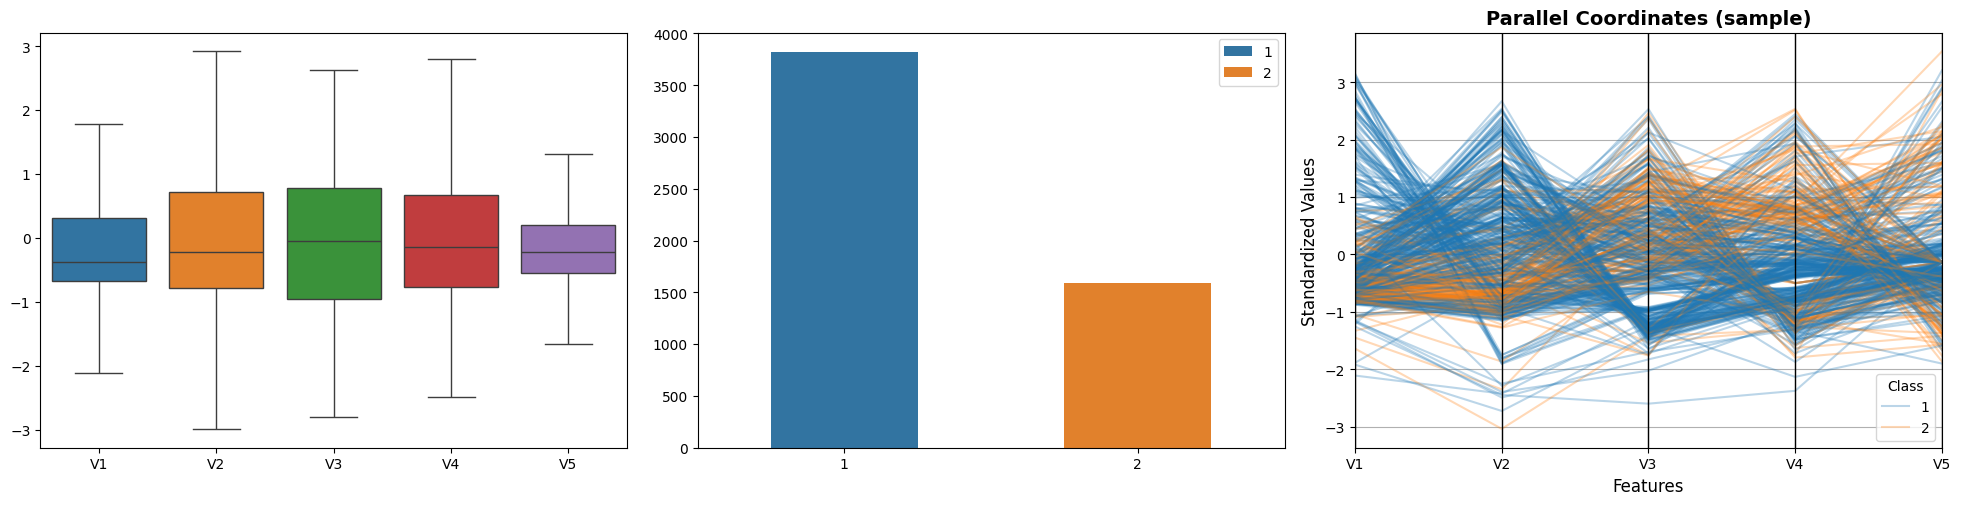

In [7]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Campiona per rendere il grafico leggibile
df_sample = df.sample(n=min(500, len(df)), random_state=42)

parallel_coordinates(
    frame=df_sample,  # Usa campione
    class_column="class",
    color=sns.color_palette("tab10", n_colors=2),
    ax=axs[2],
    alpha=0.3  # Trasparenza per vedere meglio
)
axs[2].set_title("Parallel Coordinates (sample)", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Features", fontsize=12)
axs[2].set_ylabel("Standardized Values", fontsize=12)
axs[2].legend(title='Class', loc='best')
plt.show()

To investigate on the **feature correlation** we calculate a correlation matrix and plot it as a heatmap. We notice that each feature have a very weak pairwise correlation with each other, almost scoring zero. This aspect suggests that perhaps, as it happened for the scaling, the data we have is already been pre-processed in a earlier stage.

To further improve our understanding on data, we also plotted
- Five couples of **violin plots**, with the $i$-th couple providing insight about how the $i$-th feature is distributed for both the classes.
- A **scatter matrix** that shows a scatter-plot for each couple of features and gives us a visual confirm about the extremely low correlation between each couple of features.

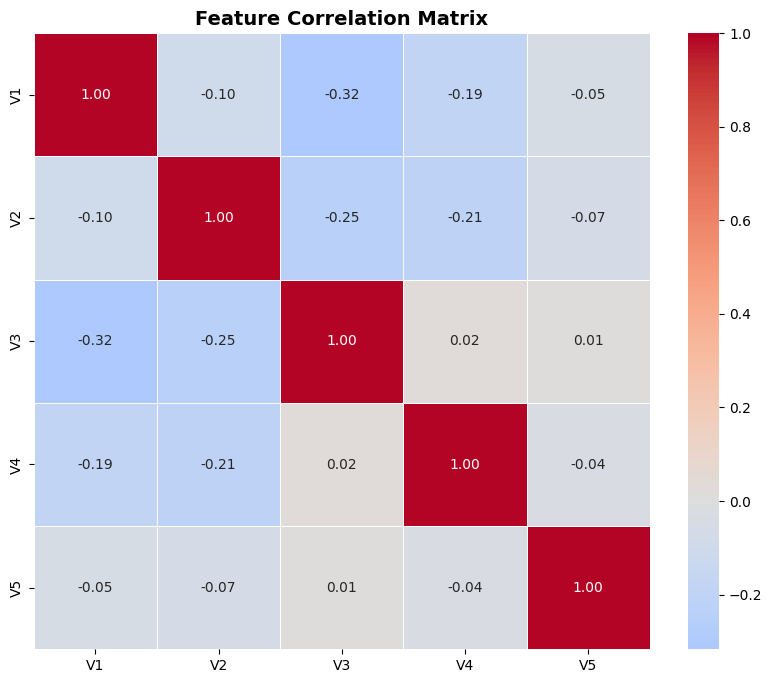

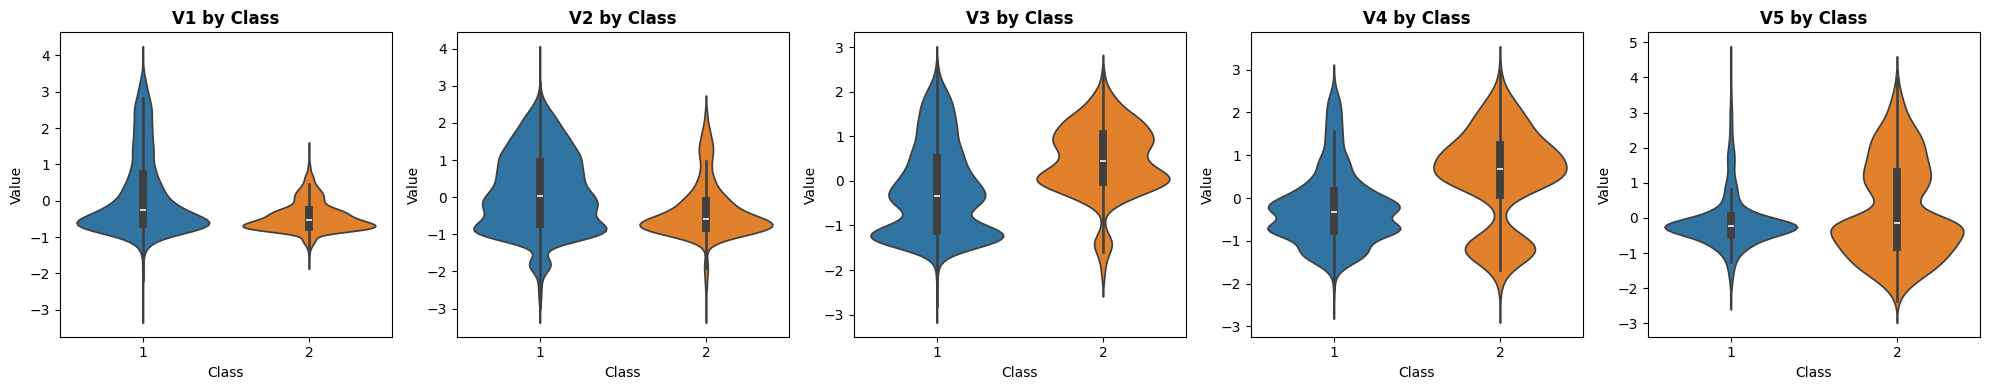

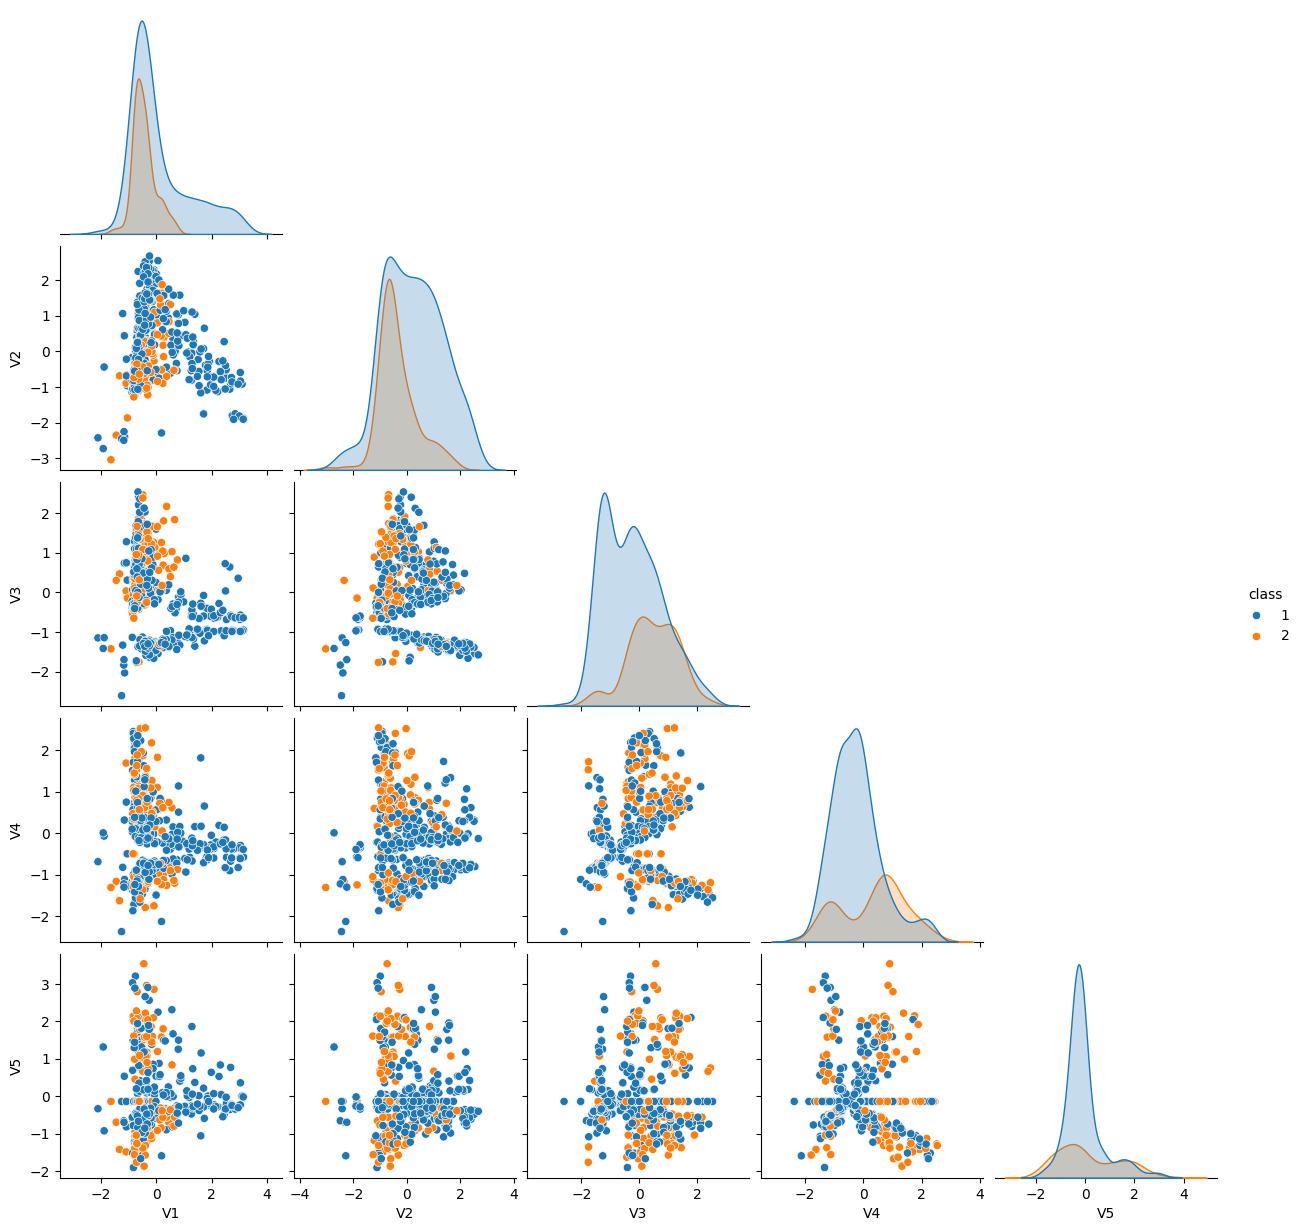

In [8]:
#  CORRELAZIONE TRA FEATURES
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

# DISTRIBUZIONE PER CLASSE (violin plot)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, col in enumerate(data.columns):
    df_plot = data.copy()
    df_plot['class'] = labels
    sns.violinplot(data=df_plot, 
                   x='class', 
                   y=col, 
                   hue='class',  
                   palette='tab10', 
                   legend=False,  
                   ax=axes[idx])
    axes[idx].set_title(f'{col} by Class', fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Value')
plt.tight_layout()
plt.show()

#PAIRPLOT 
df_sample = data.sample(n=500, random_state=42).copy()
df_sample['class'] = labels[df_sample.index]
sns.pairplot(df_sample, hue='class', palette='tab10', diag_kind='kde', corner=True)
plt.show()

## 2. Preprocessing

Once we obtained a clear idea of how our data looks like, the next step is to preprocess it aiming to make it suitable for the elaboration with Data Mining models.

First se set some constants that will be useful in the continuation of our study

In [ ]:
# Preprocessing variables
RANDOM_SEED = 42	# To enable riproducibility of our experiments
TRAIN_SIZE = 0.75	# To set the percentage of data that will be used for training our models

### 2.1 Missing values handling

To detect missing values on our data, we create a dataframe containing information about NA (not available) istances with the `is_na()` method, then we render a description of this dataset, and we discover that **there is no missing data**, so there is no need to think of operations to manage it.

In [10]:
data.isna().describe()

V1     V2     V3     V4     V5
count    5404   5404   5404   5404   5404
unique      1      1      1      1      1
top     False  False  False  False  False
freq     5404   5404   5404   5404   5404

### 2.2 Train-Test split

At this point we perform train test split according to the TRAIN_SIZE variable we set above; in addition, we map "1" and "2" labels in 0 and 1 because some models, for instance XGBoost, cannot deal with strings as labels or prefere label values starting from 0. We set the `stratify` argument such a way that a stratified sampling is performed and the class proportion is the same both in the train and in the test set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, stratify=labels, random_state=RANDOM_SEED)

y_train = y_train.cat.rename_categories({"1": 0, "2": 1})
y_test = y_test.cat.rename_categories({"1": 0, "2": 1})

np.unique_counts(y_test); np.unique_counts(y_train)

UniqueCountsResult(values=array([0, 1]), counts=array([2863, 1190]))

After the set is split we save all the partitions in csv format so that we can use them in the other notebook, `hyperparameter_tuning.ipynb` where we perform hyperparameter tuning for our models.

In [38]:
X_train.to_csv("data/X_train.csv", sep=",", index=False)
X_test.to_csv("data/X_test.csv", sep=",", index=False)
y_train.to_csv("data/y_train.csv", sep=",", index=False)
y_test.to_csv("data/y_test.csv", sep=",", index=False)

### 2.3 Balancing

Given that our dataset is highly unbalanced, there are two possible rebalancing approaches: undersampling and oversampling.
We choose to explore both these approaches to determine which of these best improves the model performances.

We perform the balancing after the train test split only on the train set because both the techniques, if applied to the entire dataset, would cause data leakage since they modify the training set distribution based on the knowledge of the test set one, and we must always assume that we don't know anything about the test set.

For the undersampling approach we use the class `RandomUnderSampler` and we obtain that both the classes have the dimension of the smaller one.

In [39]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
np.unique_counts(y_train_under)

UniqueCountsResult(values=array([0, 1]), counts=array([1190, 1190]))

And se save the obtained datasets

In [14]:
X_train_under.to_csv("data/X_train_under.csv", sep=",", index=False)
y_train_under.to_csv("data/y_train_under.csv", sep=",", index=False)

For the oversampling approach we use the class `ADASYN` (see documentation <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html">here</a>) and we obtain that both the classes have the dimension of the larger one.

In [15]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
# y_train_over = y_train_over.cat.rename_categories({"1": 0, "2": 1})

np.unique_counts(y_train_over)

UniqueCountsResult(values=array([0, 1]), counts=array([2857, 2960]))

And se save the obtained datasets

In [16]:
X_train_over.to_csv("data/X_train_over.csv", sep=",", index=False)
y_train_over.to_csv("data/y_train_over.csv", sep=",", index=False)

### 2.3 Reduction

#### 2.3.1 PCA reduction

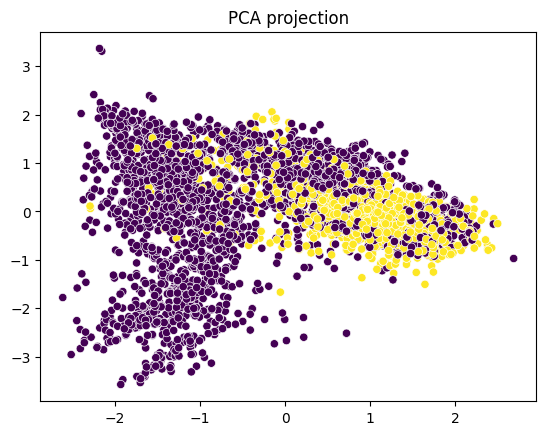

((4053, 2), (1351, 2))

In [17]:
pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

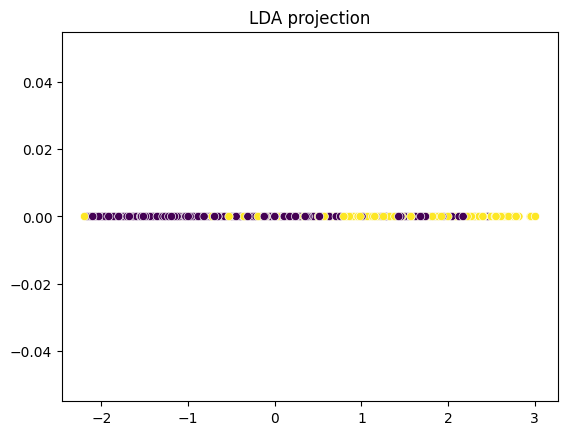

((4053, 1), (1351, 1))

In [18]:
lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

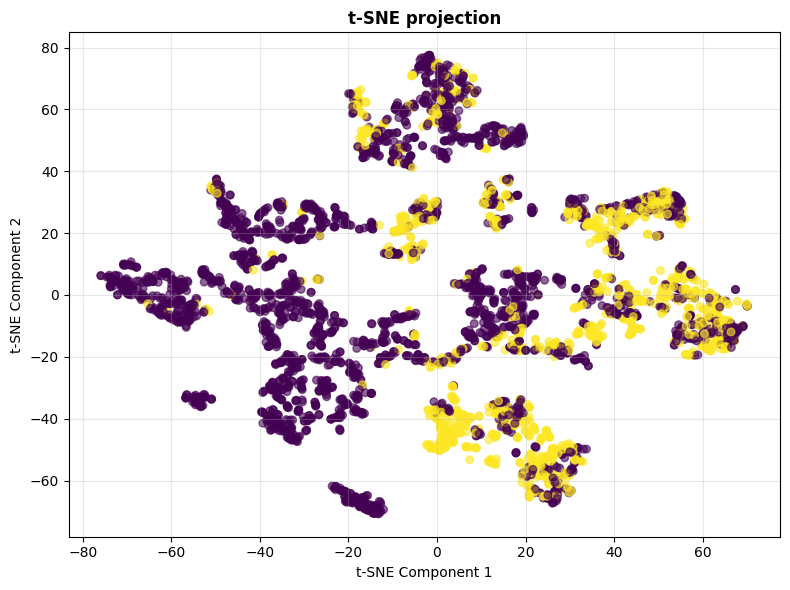

X_train_tsne shape: (4053, 2)


In [ ]:
tsne_reductor = TSNE(n_components=2, random_state=42, perplexity=30)

X_train_tsne = tsne_reductor.fit_transform(X_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
                      c=y_train.values.astype(int), alpha=0.6, s=30)
plt.title('t-SNE projection', fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"X_train_tsne shape: {X_train_tsne.shape}")

## 3. Classification

In [20]:
models_base = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=RANDOM_SEED, probability=True),
    "SVC_PCA": SVC(probability=True, random_state=42), # SVC with PCA preprocessing
    "SVC_UMAP": SVC(probability=True, random_state=42), # SVC with UMAP preprocessing
    "MLP": MLPClassifier(random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_SEED),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(),
}

To improve our experiments, we create a custom ensemble classifier

In [21]:
class EnsembleClassifier:
	def __init__(self, model_names: list):
		self.model_names = model_names
		self.ensemble_models = {}
		for name in model_names:
			self.ensemble_models[name] = models_base[name]
		
	def fit(self, X_train, y_train):
		for model_name, model_istance in self.ensemble_models.items():
			model_istance.fit(X_train, y_train)  

	# Using "Soft Voting" as foving policy
	def predict(self, X_test):
		self.y_proba_agg = np.zeros(shape=(y_test.shape[0],))
		for model_name, model_istance in self.ensemble_models.items():
			self.y_proba_agg += model_istance.predict_proba(X_test)[:, 1]
		self.y_proba_agg /= len(self.ensemble_models.keys())
		return self.y_proba_agg.round()
	
	def predict_proba(self, X_test):
		return self.y_proba_agg
		

ensemble = EnsembleClassifier(["SVC", "XGBoost", "AdaBoost"])
models_base["CustomEnsemble"] = ensemble

To further explore, we also decided to implement a Deep Learning model, in particular a convolutional network, based on Conv1D layers

In [22]:
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D

class DeepConvolutionalModel:
	def __init__(self, n_conv_layers=2, 
			  n_filters_in_layers=[32, 16], 
			  kernel_size=2, 
			  dense_layer_units=[10],
			  optimizer="RMSprop",
			  loss="binary_crossentropy",
			  metrics=["accuracy"]):
		assert n_conv_layers > 0
		assert n_conv_layers == len(n_filters_in_layers)

		initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_SEED)

		# Building the Convolutional Neural network
		layers = [Conv1D(filters=n_filters_in_layers[0], kernel_size=kernel_size, activation='relu', input_shape=(5, 1), padding="same", kernel_initializer=initializer)]
		for i in range(n_conv_layers):
			layers.append(Conv1D(filters=n_filters_in_layers[i], kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer=initializer))
		layers.append(GlobalAveragePooling1D())
		for i in range(len(dense_layer_units)):
			layers.append(Dense(dense_layer_units[i], activation='relu', kernel_initializer=initializer))
		layers.append(Dense(1, activation="sigmoid", kernel_initializer=initializer))

		# Instanciating the model
		self.model = Sequential(layers)
		self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


	def fit(self, X_train, y_train, epochs=30, batch_size=32, validation_split=0.2):
		self.X_train_tensor = X_train.to_numpy(dtype=np.float32)[..., np.newaxis]
		self.X_test_tensor = X_test.to_numpy(dtype=np.float32)[..., np.newaxis]
		self.y_train_tensor = y_train.to_numpy()
		self.y_test_tensor = y_test.to_numpy()

		history = self.model.fit(
			self.X_train_tensor,
			self.y_train_tensor,
			epochs=epochs,
			batch_size=batch_size,
			validation_split=validation_split,
			verbose=0
		)

	def predict(self, X_test):
		self.probs = self.model.predict(self.X_test_tensor)
		return self.probs.round()

	def predict_proba(self, X_test):
		return self.probs
	
convNetwork = DeepConvolutionalModel()
models_base["DeepConvModel"] = convNetwork

In [23]:
import copy
models = {
    name: {
        sampling: copy.deepcopy(model) 
        for sampling in ["over", "under", "none"]
    } 
    for name, model in models_base.items()
}

configs = {
	'none': (X_train, y_train),
	'over': (X_train_over, y_train_over),
	'under': (X_train_under, y_train_under)
}

# Heatmap and Roc curve render functions require a different color name specification
colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}

In [24]:
# Defining a function that, given a model, returns the results of its training
# Revised to include PCA/UMAP preprocessing for specific models
def compute_results(model_name: str, **train_config):
    results = {}  
    
    needs_pca = ("SVC_PCA",)
    needs_umap = ("SVC_UMAP",)
    
    for idx, (strategy, (X_tr, y_tr)) in enumerate(train_config.items()):
        model = models[model_name][strategy]
        
        # Preprocessing in base al modello
        if model_name in needs_pca:
            pca = PCA(n_components=2)
            X_tr_processed = pca.fit_transform(X_tr)
            X_te_processed = pca.transform(X_test)
            
        elif model_name in needs_umap:
            umap = UMAP(n_components=2, random_state=42)
            X_tr_processed = umap.fit_transform(X_tr, y=y_tr)  # Supervisionato
            X_te_processed = umap.transform(X_test)
            
        else:
            X_tr_processed = X_tr
            X_te_processed = X_test
        
        model.fit(X_tr_processed, y_tr)    
        
        y_pred = model.predict(X_te_processed)
        
        if model_name in ("CustomEnsemble", "DeepConvModel"):
            y_pred_proba = model.predict_proba(X_te_processed)
        else:
            y_pred_proba = model.predict_proba(X_te_processed)[:, 1]
        
        results[strategy] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan, 
            'feature_importances': model.feature_importances_ if model_name in ("DecisionTree", "RandomForest", "AdaBoost", "XGBoost") else None,
            'X_train_processed': X_tr_processed,
            'X_test_processed': X_te_processed
        }
        
        # Salva reducer dentro la strategia
        if model_name in needs_pca:
            results[strategy]['pca'] = pca
        if model_name in needs_umap:
            results[strategy]['umap'] = umap

        with open(f"results/{model_name}_{strategy}.json", mode="w") as file:
            json.dump(classification_report(y_test, results[strategy]["y_pred"], output_dict=True), file, indent="\t")
    
    return results

In [25]:
from sklearn.preprocessing import LabelEncoder
# Defining a function that, given a model, renders plots for its results
# Revised to include PCA decision boundary rendering for specific models
def render_plots(model_name: str, results: dict, colors: dict):
    if model_name == "DecisionTree":
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        fig.suptitle('Decision Tree Structures (max depth=3)', fontsize=16, y=0.98)

        for idx, strategy in enumerate(configs.keys()):
            model = results[strategy]['model']
            plot_tree(model, 
                      feature_names=dataset.feature_names,
                      class_names=['Classe 0', 'Classe 1'],  
                      filled=True, 
                      max_depth=3,
                      fontsize=8,
                      ax=axes[idx])
            axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

    if model_name in ("SVC_PCA", "SVC_UMAP"):   
        le = LabelEncoder()
        y_test_numeric = le.fit_transform(y_test)
        cm_colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('SVM - Decision Boundaries', 
                     fontsize=16, fontweight='bold', y=1.02)

        for idx, strategy in enumerate(['none', 'over', 'under']):
            ax = axes[idx]
            
            X_train_pca = results[strategy]['X_train_processed']
            X_test_pca = results[strategy]['X_test_processed']
            model = results[strategy]['model']
            
            y_train_numeric = le.transform(configs[strategy][1])
            
            # Crea mesh grid
            h = 0.02
            x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
            y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            
            # Predici su mesh (usa il modello già addestrato su 2D)
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = le.transform(Z)
            Z = Z.reshape(xx.shape)
            
            # Plot
            ax.contourf(xx, yy, Z, alpha=0.3, cmap=cm_colors[strategy])
            ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_test_numeric, cmap=cm_colors[strategy], 
                      edgecolors='black', s=50, alpha=0.7)
            
            ax.set_title(f'{strategy.capitalize()}\nAccuracy: {results[strategy]["accuracy"]:.3f}', fontweight='bold')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component' if idx == 0 else '')
            ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Render Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for idx, strategy in enumerate(results.keys()):
        cm = confusion_matrix(y_test, results[strategy]["y_pred"])
        sns.heatmap(cm, annot=True, cmap=colors[strategy], fmt="d", ax=axes[idx], cbar=True)
        axes[idx].set_title(f'{strategy.capitalize()}\nAccuracy: {results[strategy]["accuracy"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True' if idx == 0 else '')

    plt.tight_layout()
    plt.show()

    # Render ROC curve
    plt.figure(figsize=(10, 7))
    for strategy in results.keys():
        y_pred_proba = results[strategy]['y_pred_proba']
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        roc_colors = {k: v.lower()[:-1] for (k, v) in colors.items()}	
        plt.plot(fpr, tpr, color=roc_colors[strategy], lw=2, 
                label=f'{strategy.capitalize()} (AUC = {roc_auc:.3f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name} Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Render Feature importance
    if model_name in ("DecisionTree", "RandomForest", "AdaBoost", "XGBoost"):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for idx, strategy in enumerate(results.keys()):
            feature_importance = pd.DataFrame({
                'feature': data.columns,
                'importance': results[strategy]["feature_importances"]
            }).sort_values('importance', ascending=False)

            sns.barplot(data=feature_importance, 
                        x='importance', 
                        y='feature',
                        hue='feature',  
                        palette='viridis',
                        legend=False,
                        ax=axes[idx])
            
            for p in axes[idx].patches:
                width = p.get_width()
                y = p.get_y() + p.get_height() / 2

                axes[idx].text(
                    width - 0.01 * axes[idx].get_xlim()[1],
                    y,
                    f'{width:.3f}',
                    ha='right',
                    va='center',
                    color='white',
                    fontsize=9
                )

            axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel("Importance", fontsize=10)
            axes[idx].set_ylabel("Features" if idx == 0 else "", fontsize=10)
        
        plt.tight_layout()
        plt.show()

In [26]:
# Importing the file of the tuned iperparameters
with open("./tuned_hyperparameters.json", mode="r") as file:
    hyperparameters = json.load(file)

for model in models.keys():
    for sampling in ("over", "under", "none"):
        if model in ("DeepConvModel",): 
            continue
        elif model == "CustomEnsemble":
            for shallow_model_name in models["CustomEnsemble"][sampling].model_names:
                models.get("CustomEnsemble").get(sampling).ensemble_models[shallow_model_name].set_params(**hyperparameters.get(sampling).get(shallow_model_name).get("params"))
        elif model in ("SVC_PCA", "SVC_UMAP"):
            pass # No hyperparameter tuning for SVC_PCA/SVC_UMAP
        else:
            models.get(model).get(sampling).set_params(**hyperparameters.get(sampling).get(model).get("params"))
            print(f"{model}-{sampling}: {models.get(model).get(sampling).get_params()}")

DecisionTree-over: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-under: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
DecisionTree-none: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 24, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
NaiveBayes-over: {'priors': None, 'va

In [27]:
models_base

{'DecisionTree': DecisionTreeClassifier(random_state=42),
 'NaiveBayes': GaussianNB(),
 'KNN': KNeighborsClassifier(),
 'SVC': SVC(probability=True, random_state=42),
 'SVC_PCA': SVC(probability=True, random_state=42),
 'SVC_UMAP': SVC(probability=True, random_state=42),
 'MLP': MLPClassifier(random_state=42),
 'RandomForest': RandomForestClassifier(random_state=42),
 'AdaBoost': AdaBoostClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
    

### 3.1 Shallow Machine Learning

#### 3.1.1 Decision Tree

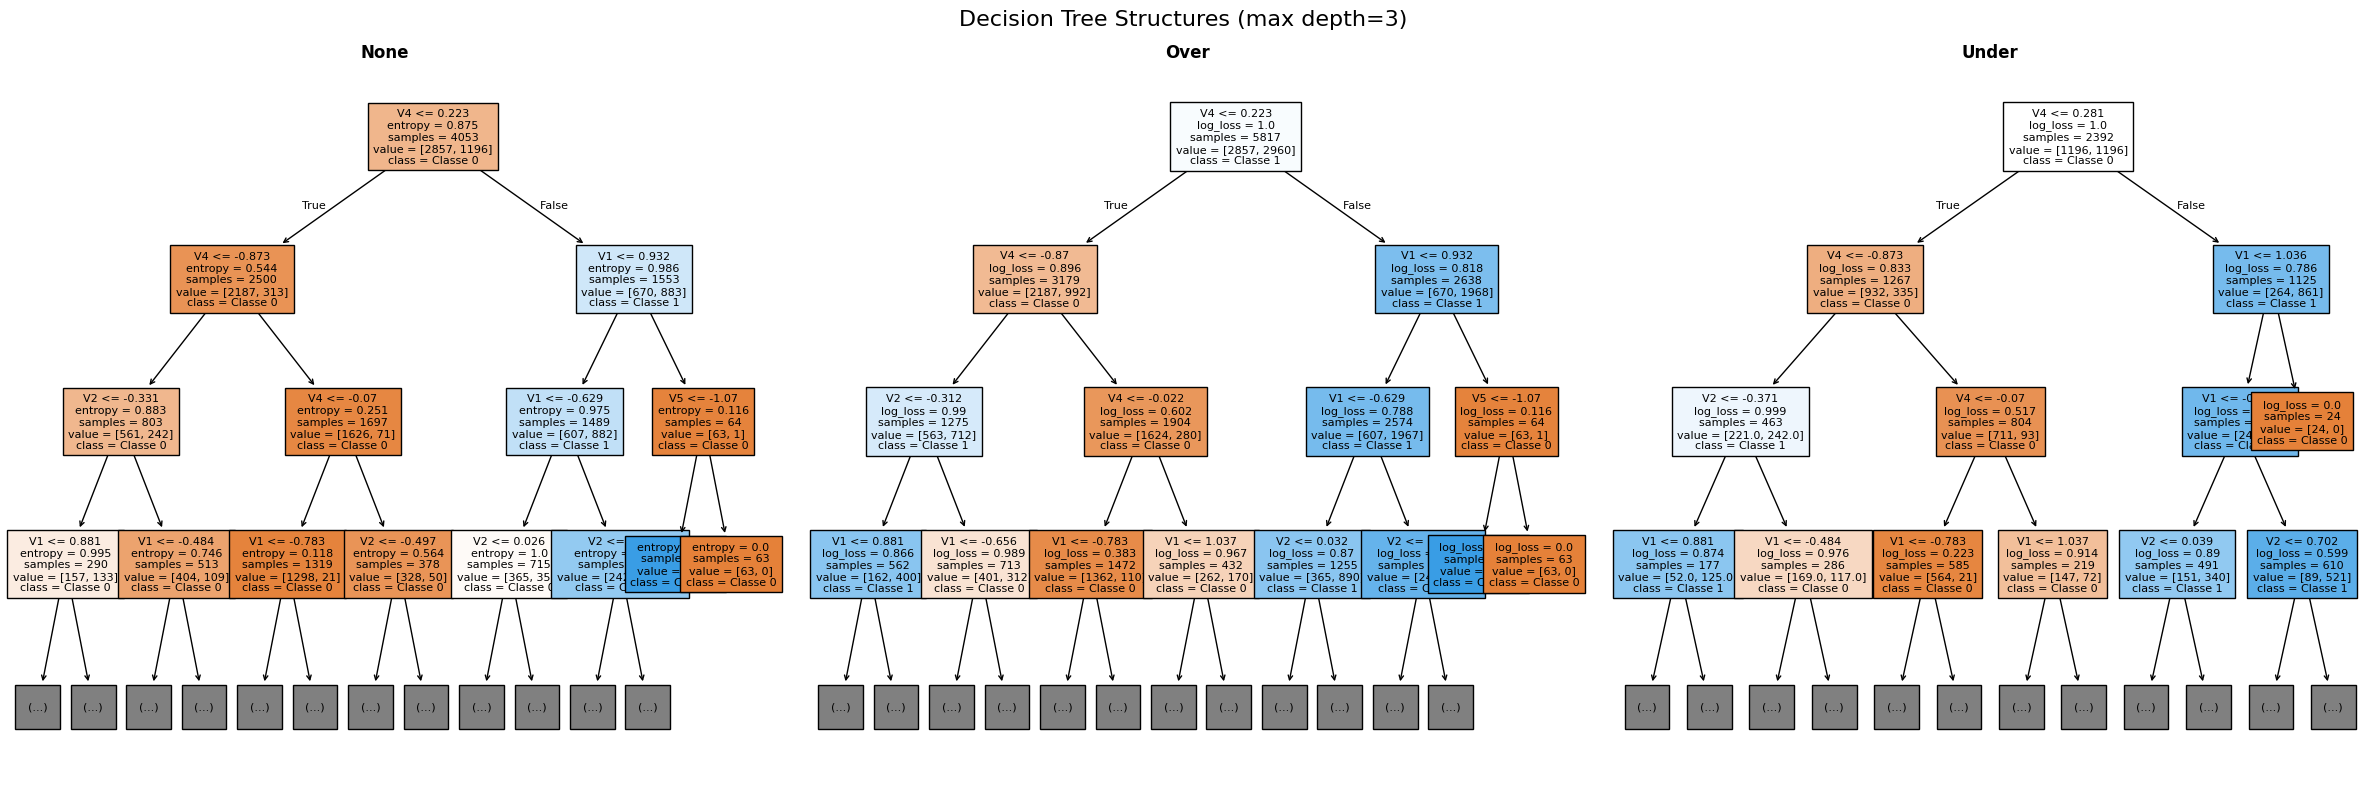

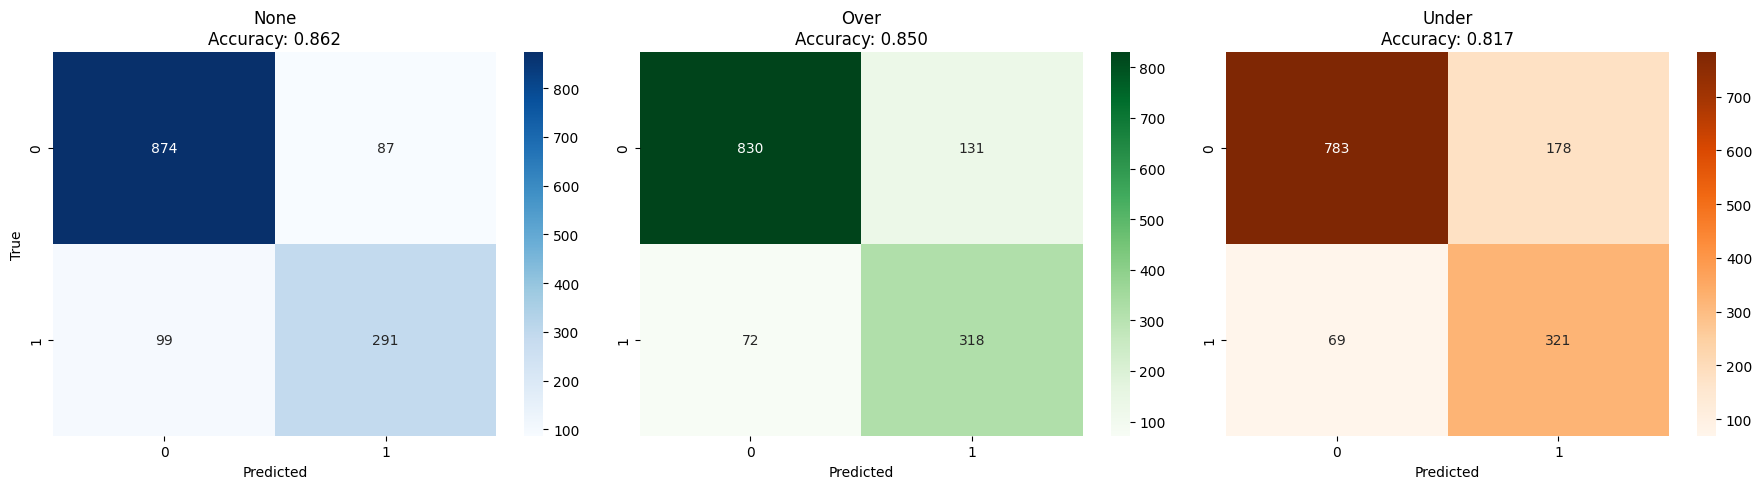

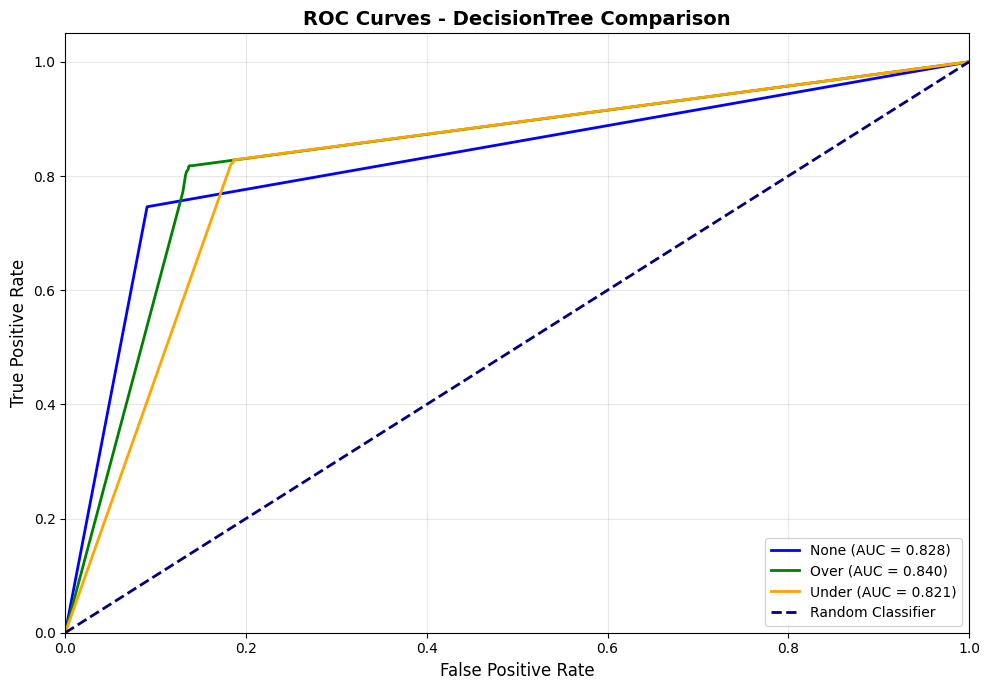

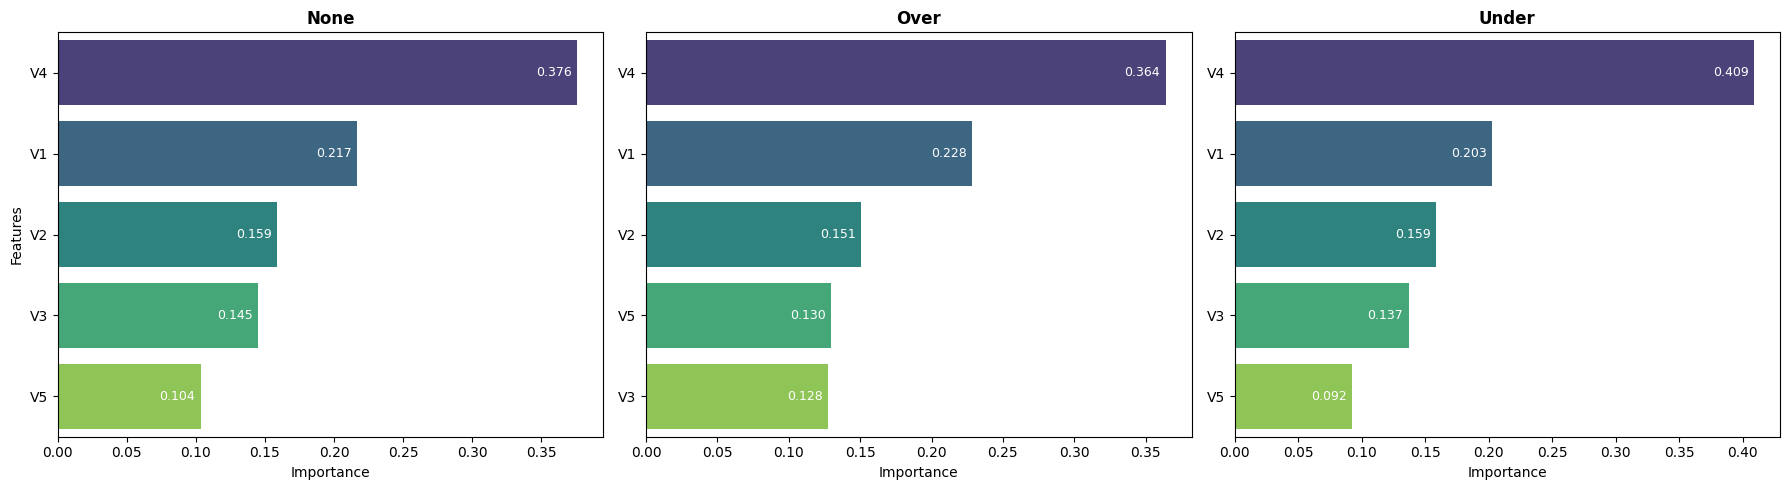

In [28]:
results = compute_results("DecisionTree", **configs)
render_plots("DecisionTree", results, colors)

#### 3.1.2 Naive Bayes

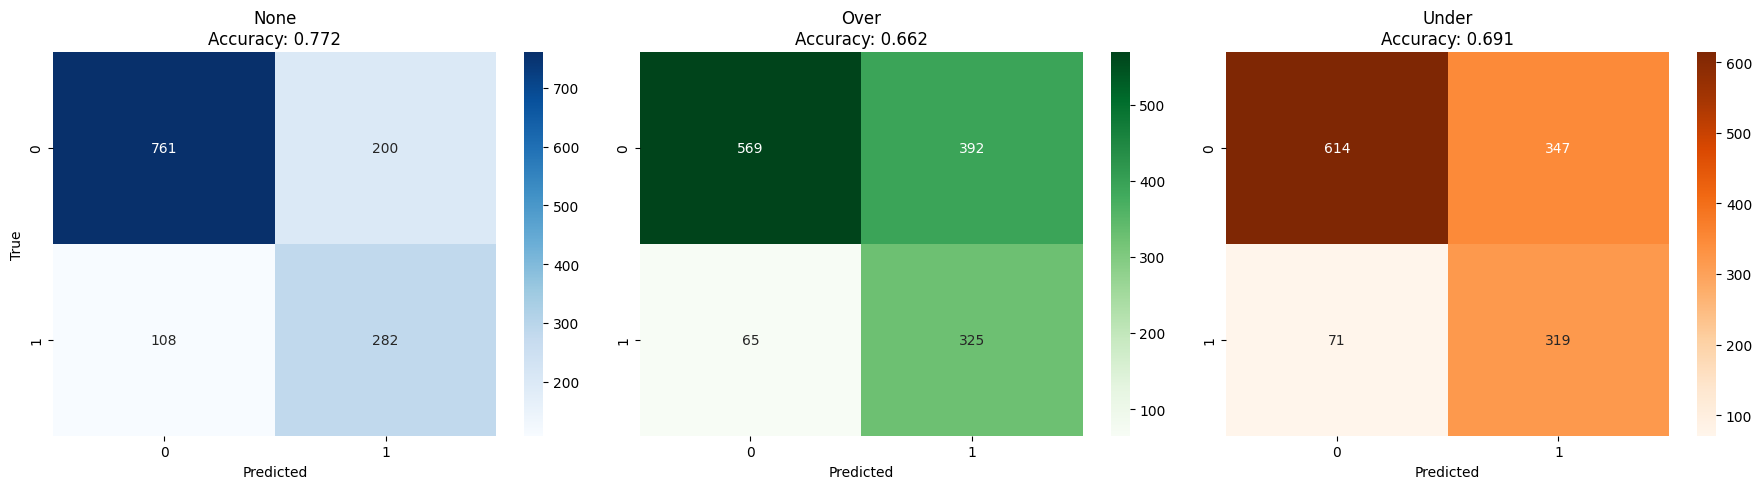

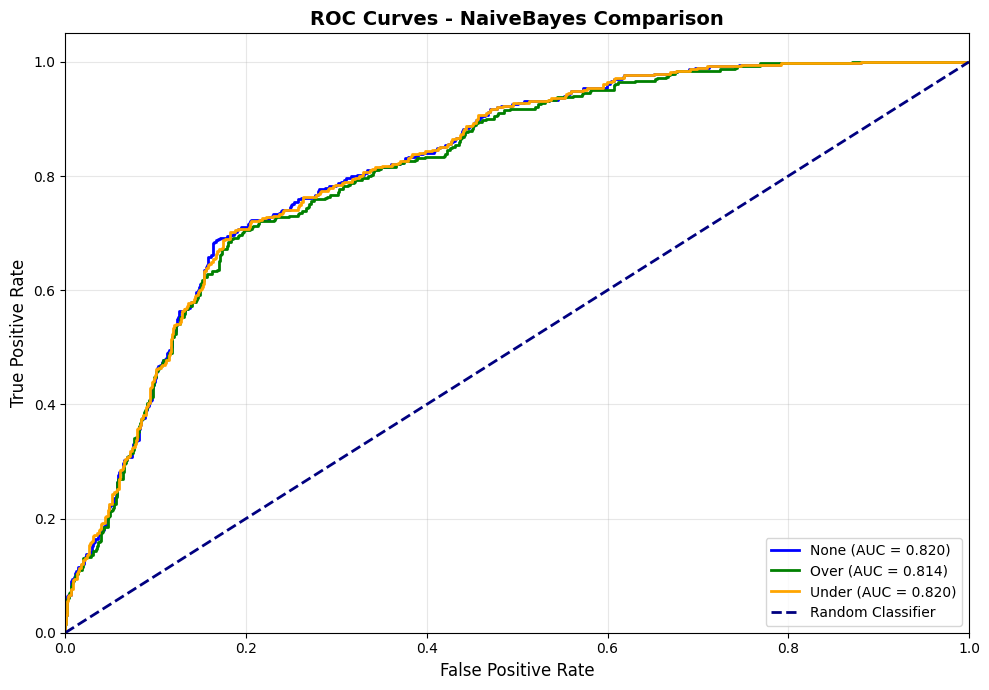

In [29]:
results = compute_results("NaiveBayes", **configs)
render_plots("NaiveBayes", results, colors)

#### 3.1.3 KNN Classifier

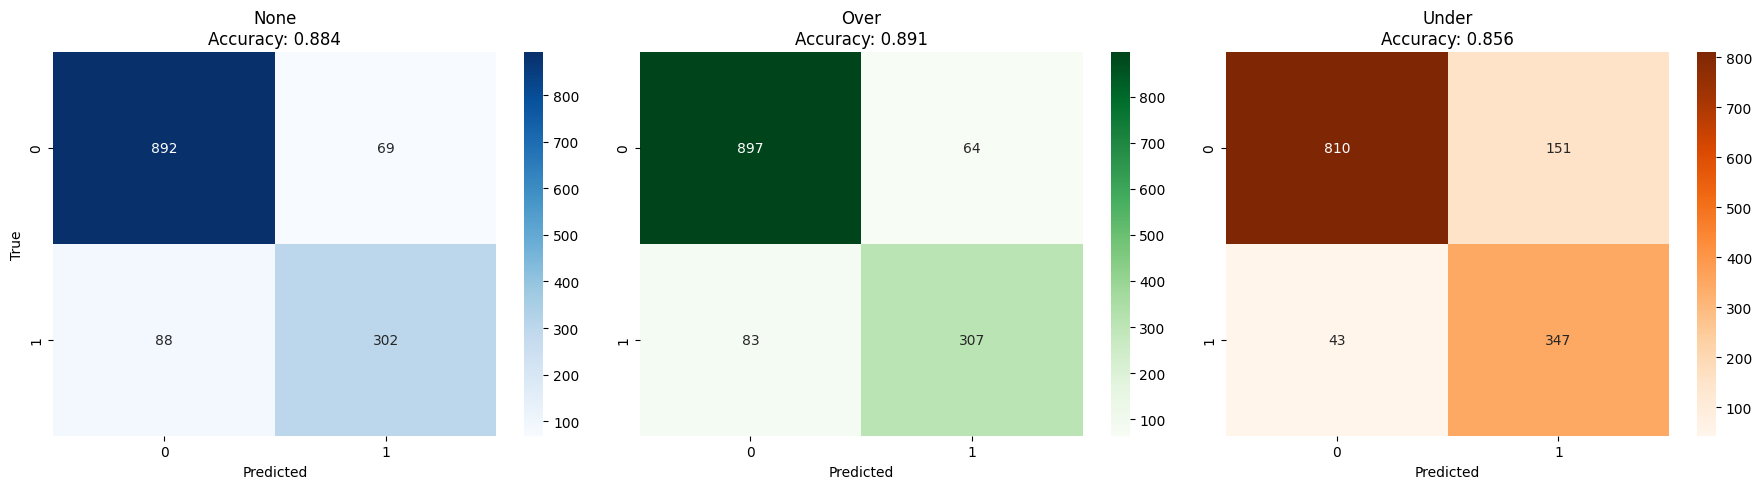

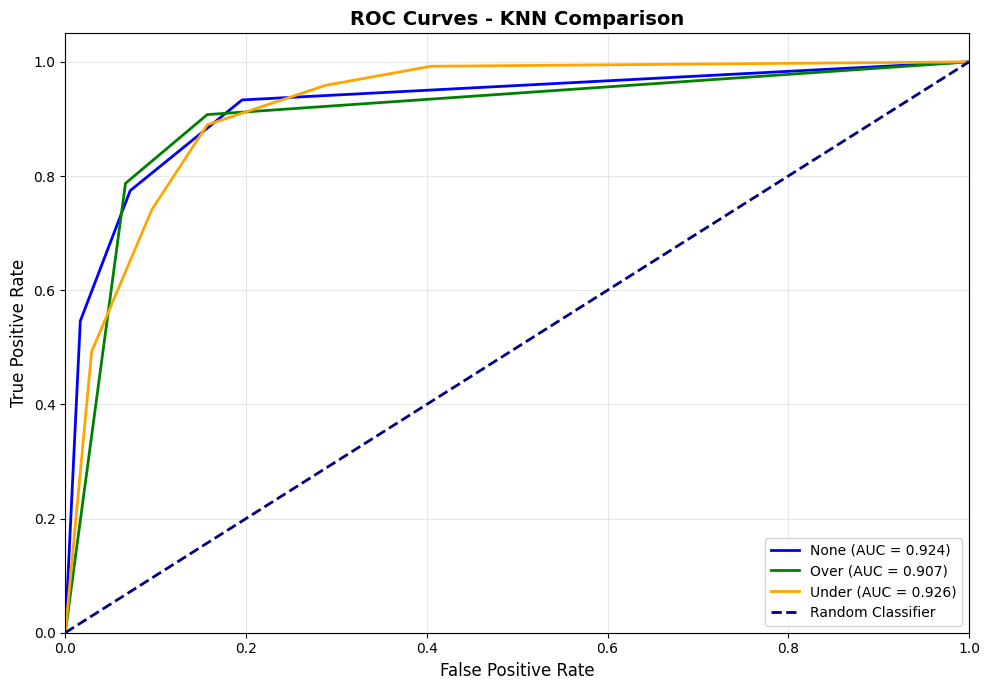

In [30]:
results = compute_results("KNN", **configs)
render_plots("KNN", results, colors)

#### 3.1.4 SVM Classifier

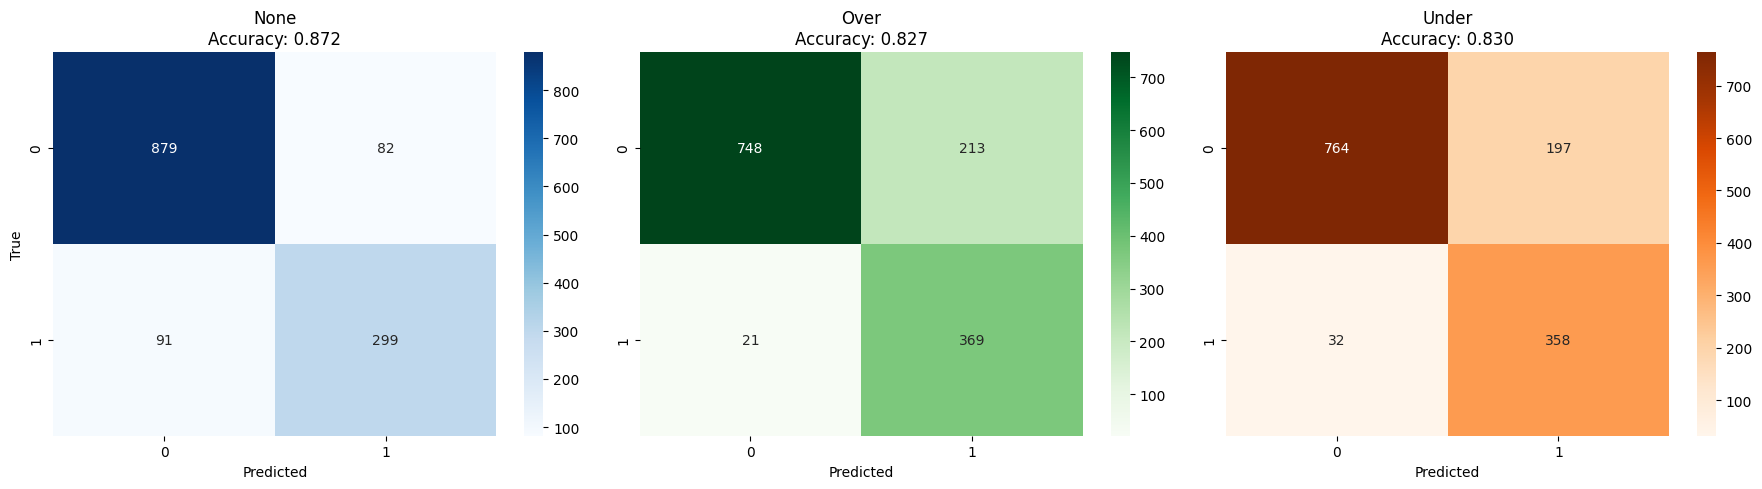

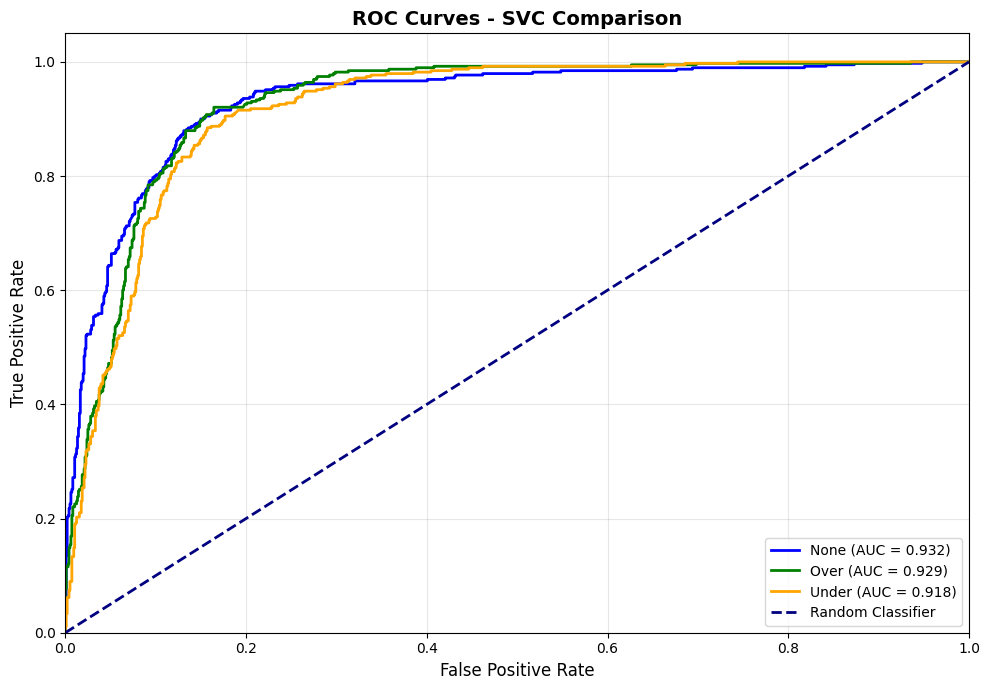

In [31]:
results = compute_results("SVC", **configs)
render_plots("SVC", results, colors)

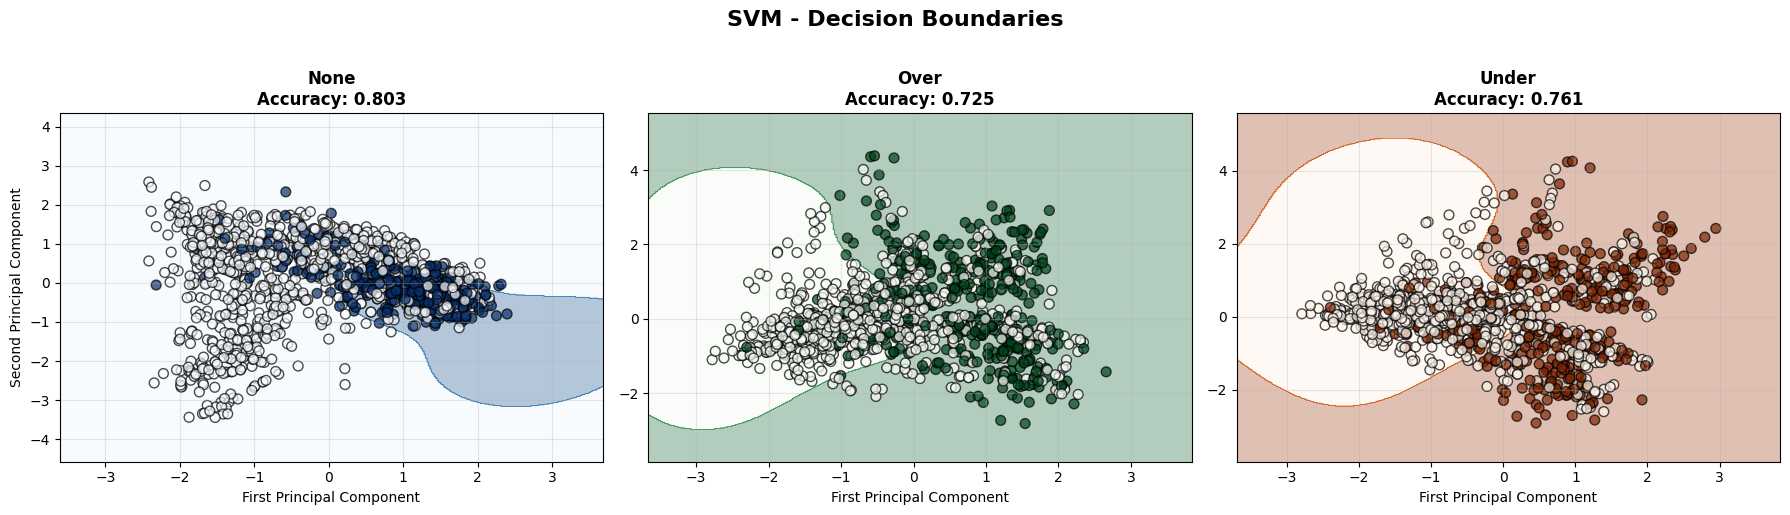

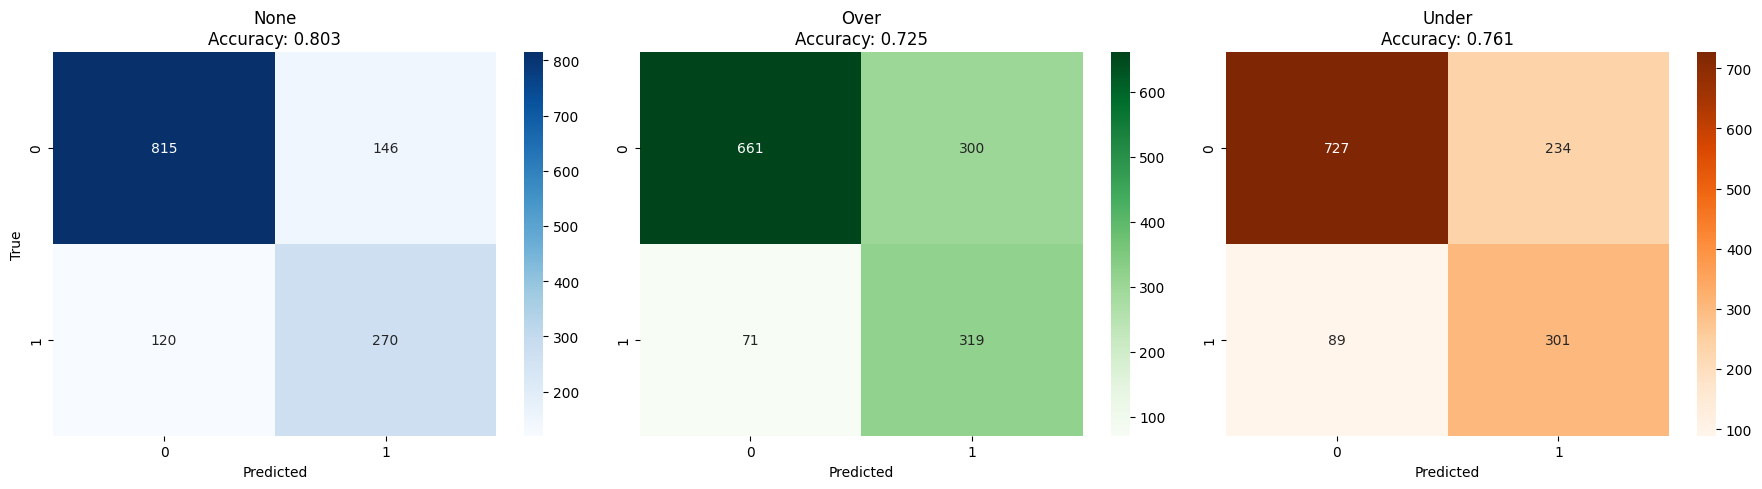

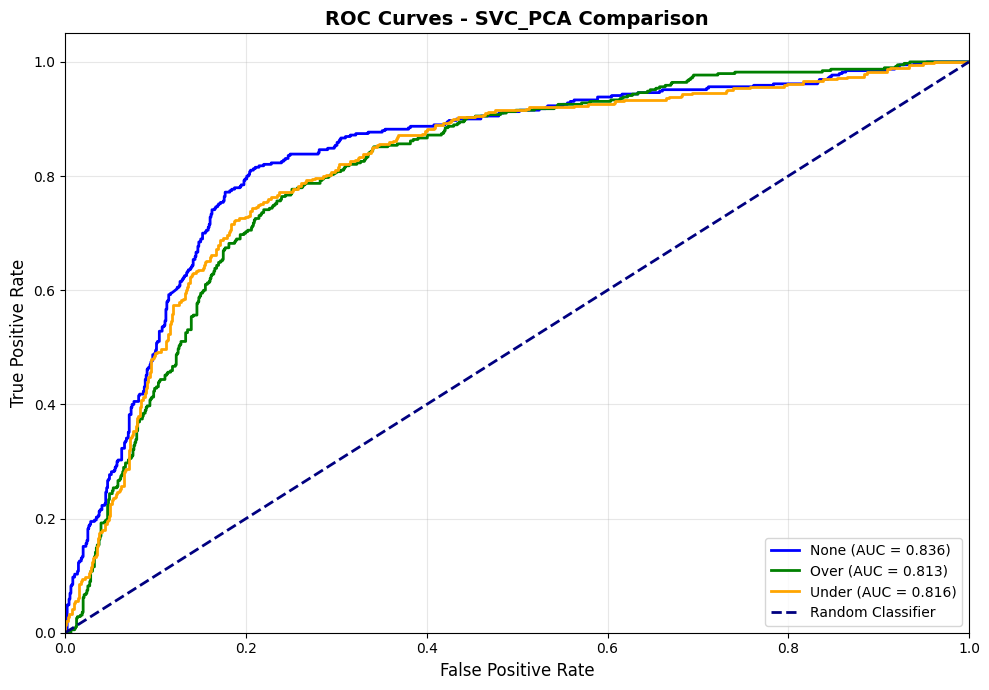

In [32]:
# SVM PCA decision boundaries rendering
results_svc_pca = compute_results("SVC_PCA", **configs)
render_plots("SVC_PCA", results_svc_pca, colors)

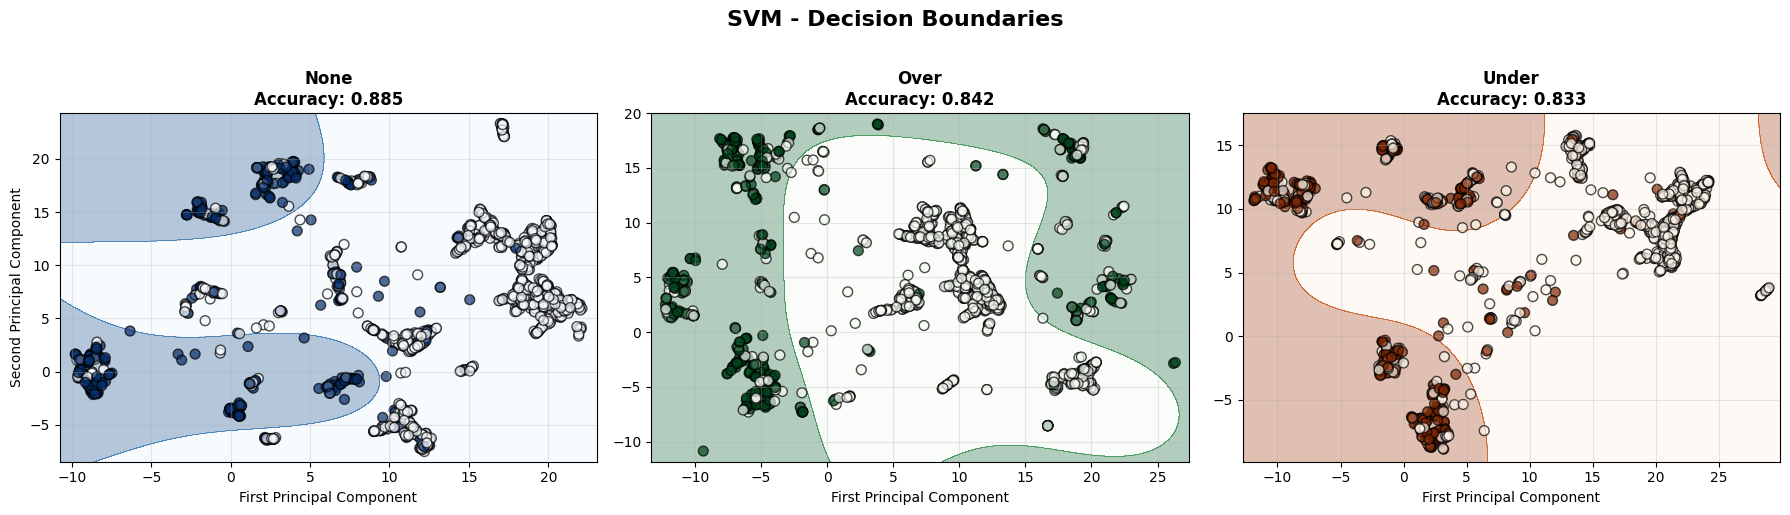

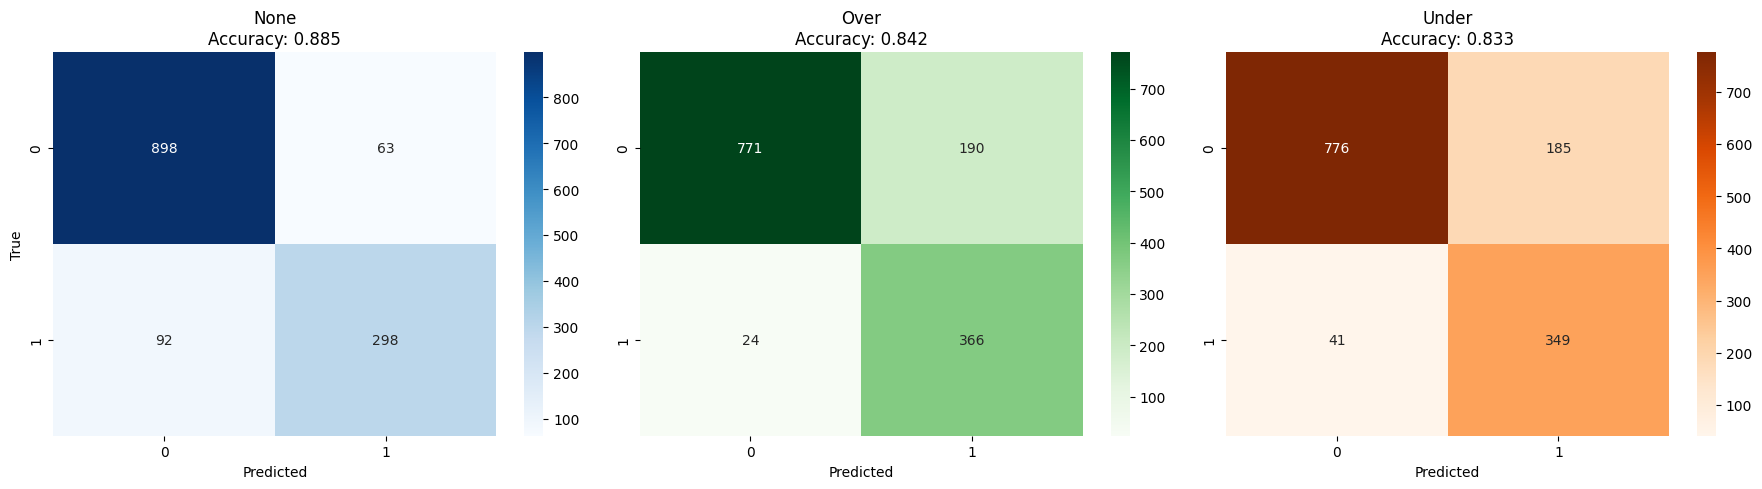

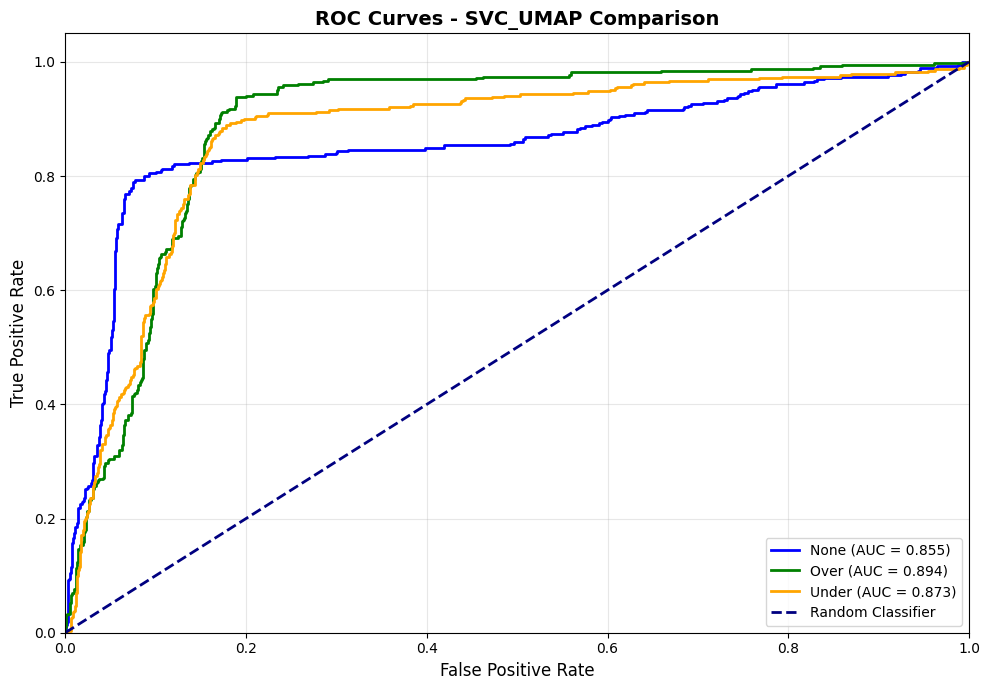

In [28]:
results_svc_umap = compute_results("SVC_UMAP", **configs)
render_plots("SVC_UMAP", results_svc_umap, colors)

### 3.2 Ensemble Classifiers Machine Learning 

#### 3.2.2 AdaBoost

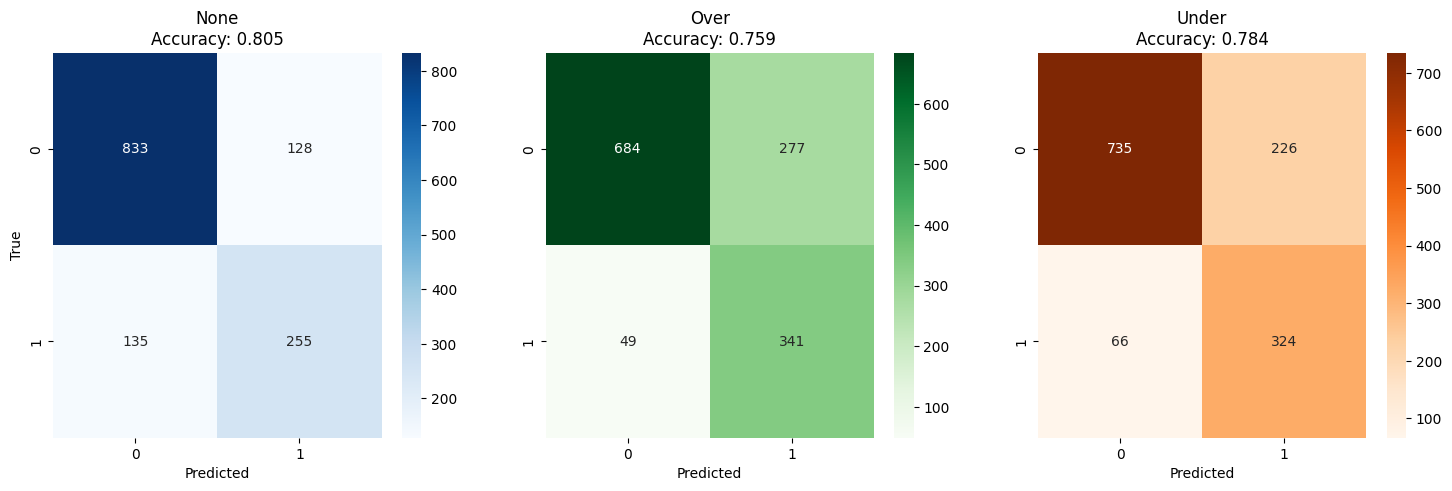

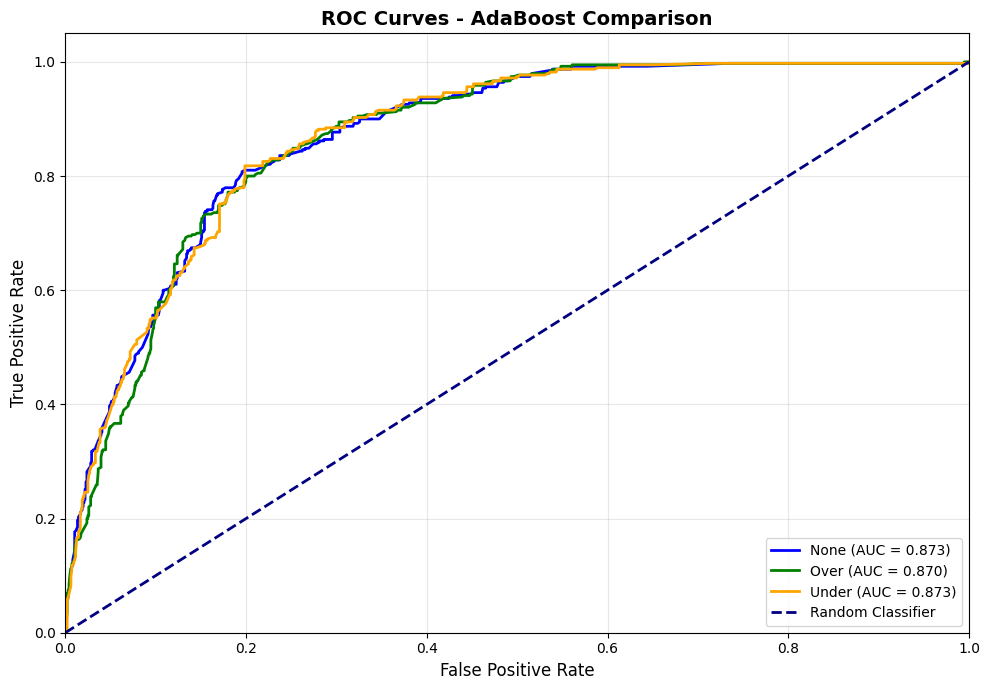

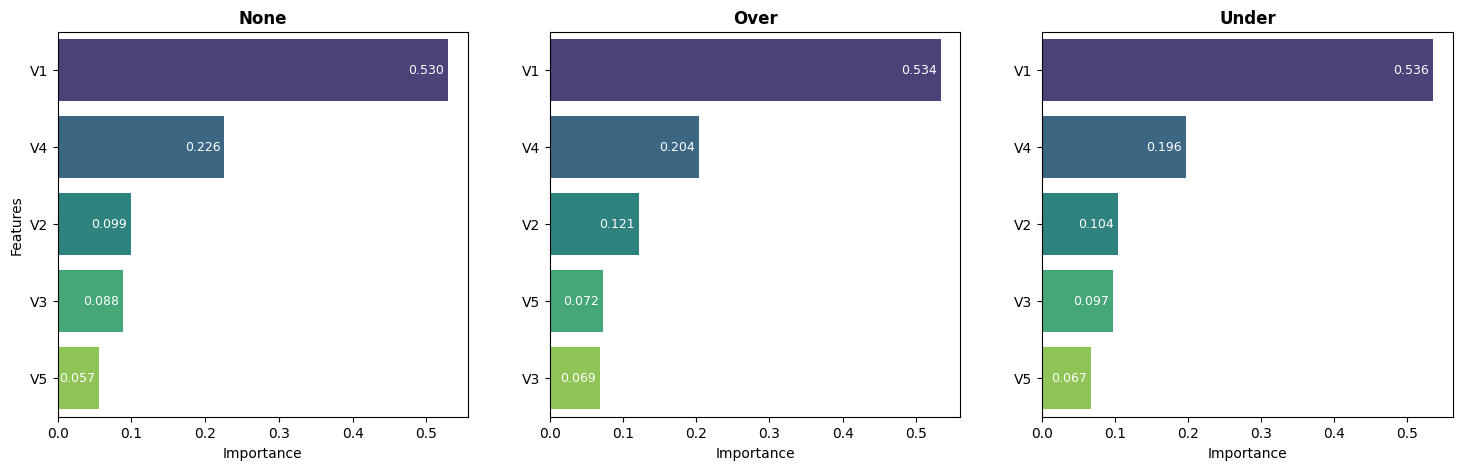

In [ ]:
results = compute_results("AdaBoost", **configs)
render_plots("AdaBoost", results, colors)

#### 3.2.3 Extreme Gradient Boosting

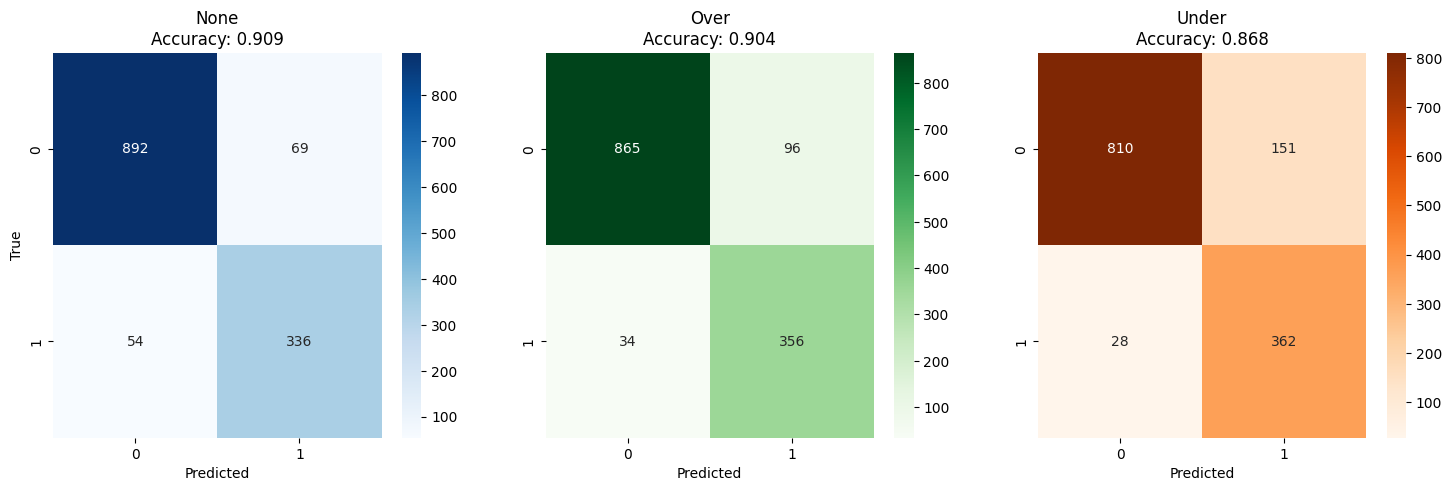

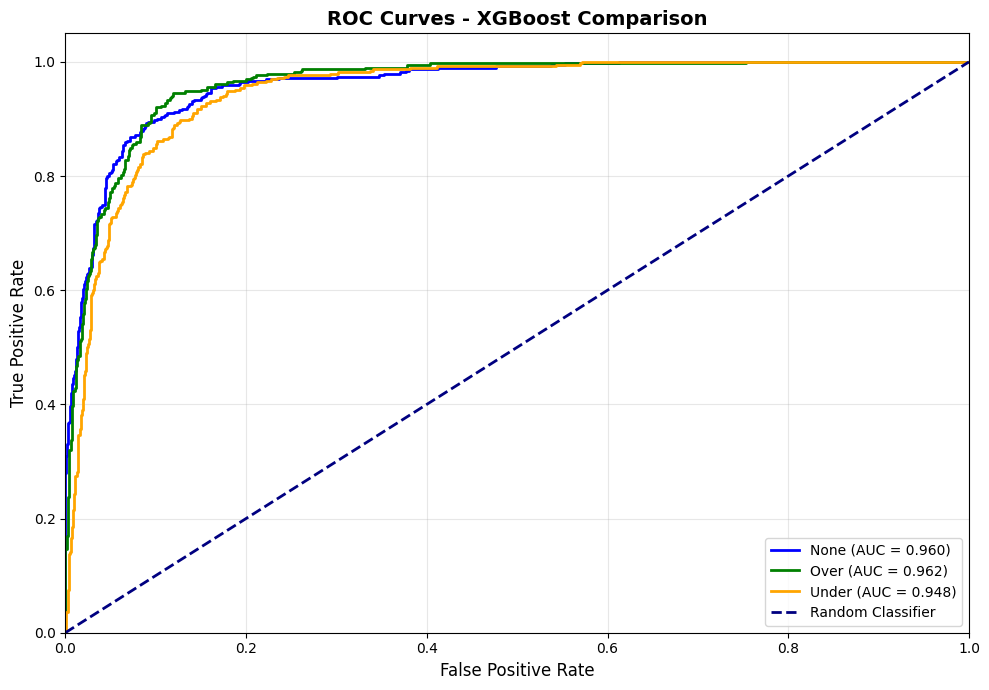

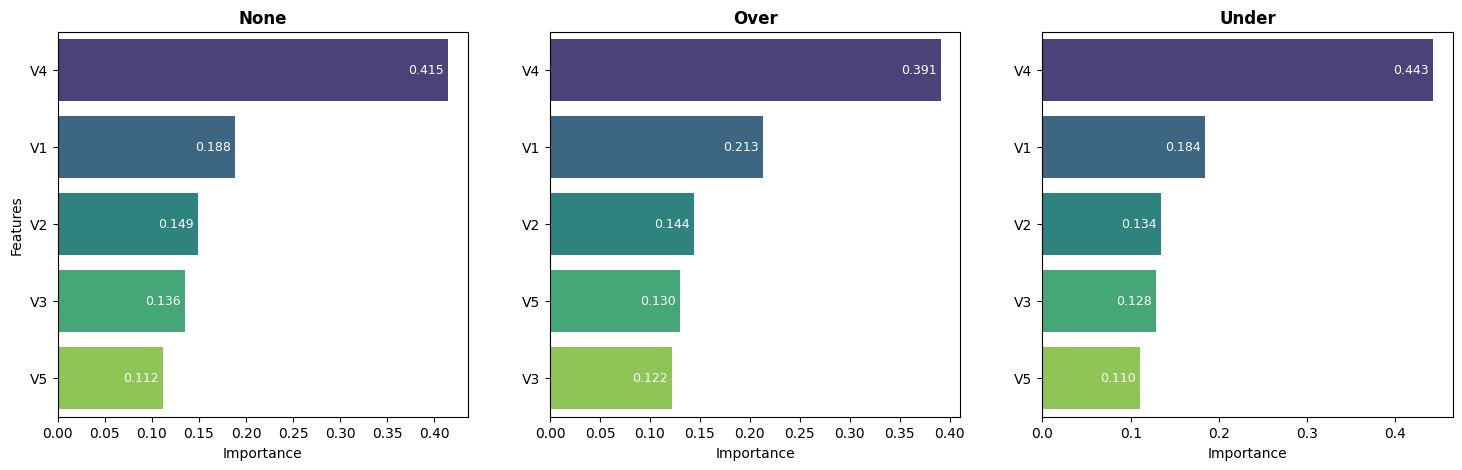

In [ ]:
results = compute_results("XGBoost", **configs)
render_plots("XGBoost", results, colors)

#### 3.2.4 Custom Ensemble

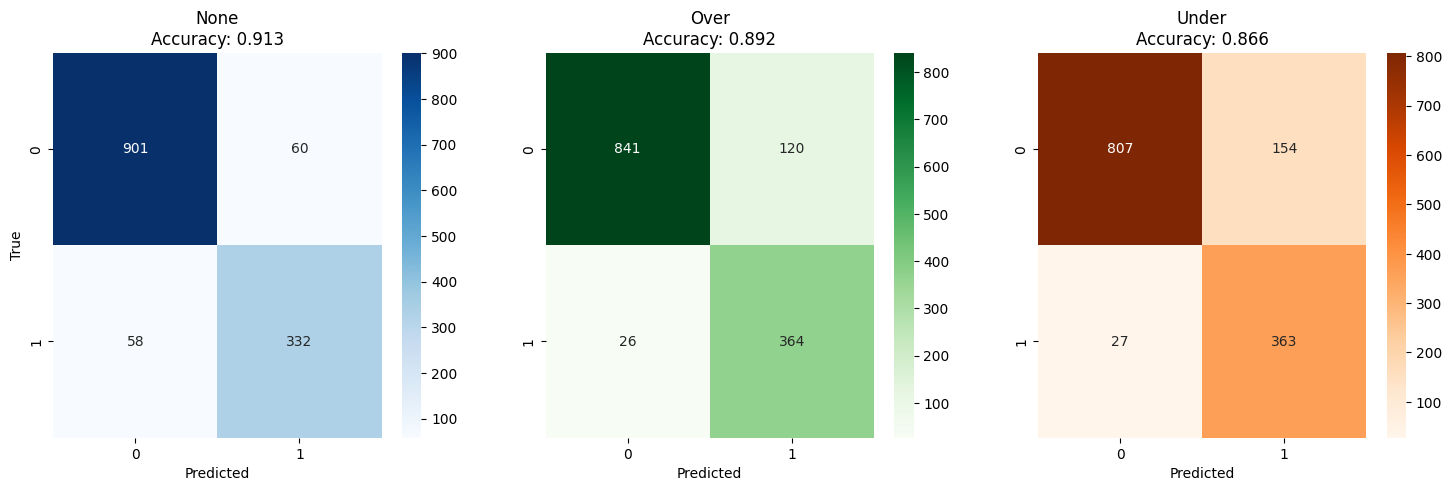

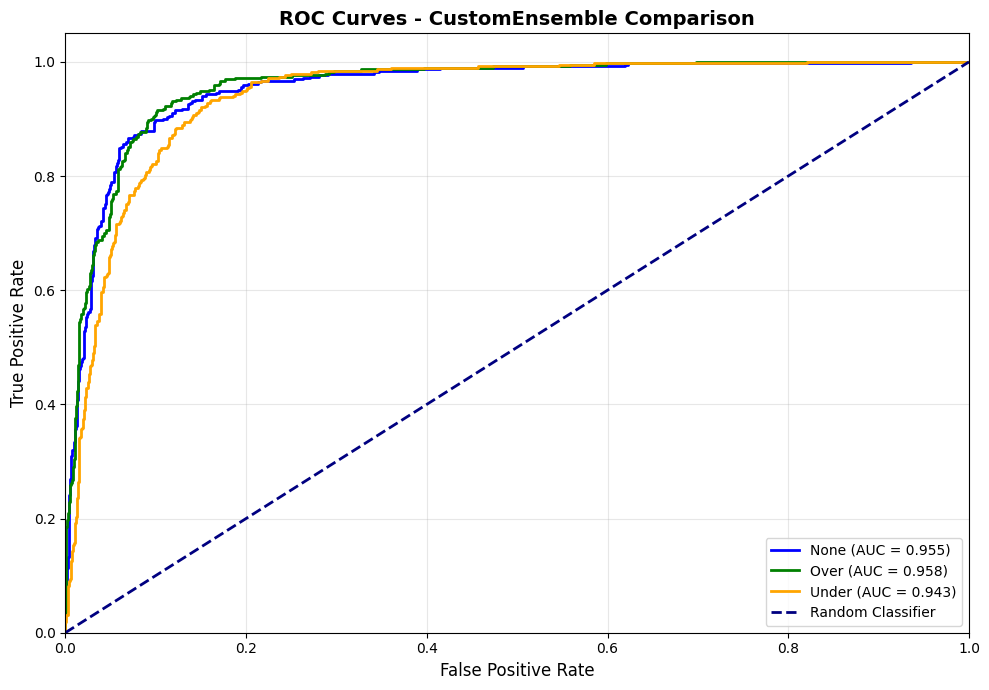

In [ ]:
results = compute_results("CustomEnsemble", **configs)
render_plots("CustomEnsemble", results, colors)

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

c:\Users\fraca\Desktop\Universita\Applied AI\DM\phoneme_classification\DM\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fraca\Desktop\Universita\Applied AI\DM\phoneme_classification\DM\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fraca\Desktop\Universita\Applied AI\DM\phoneme_classification\DM\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


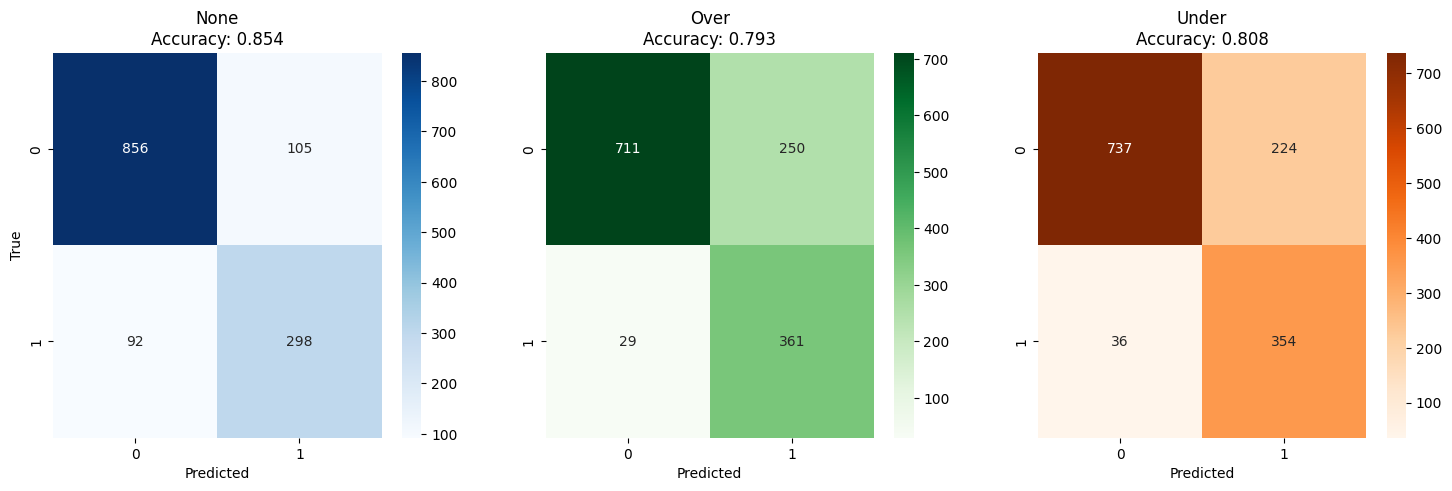

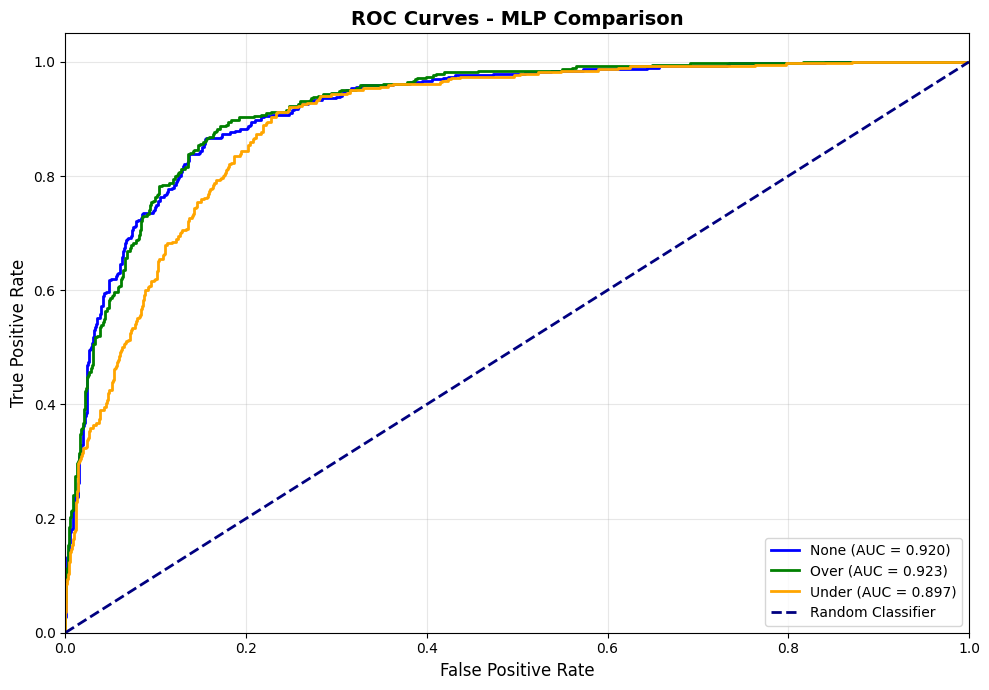

In [ ]:
results = compute_results("MLP", **configs)
render_plots("MLP", results, colors)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


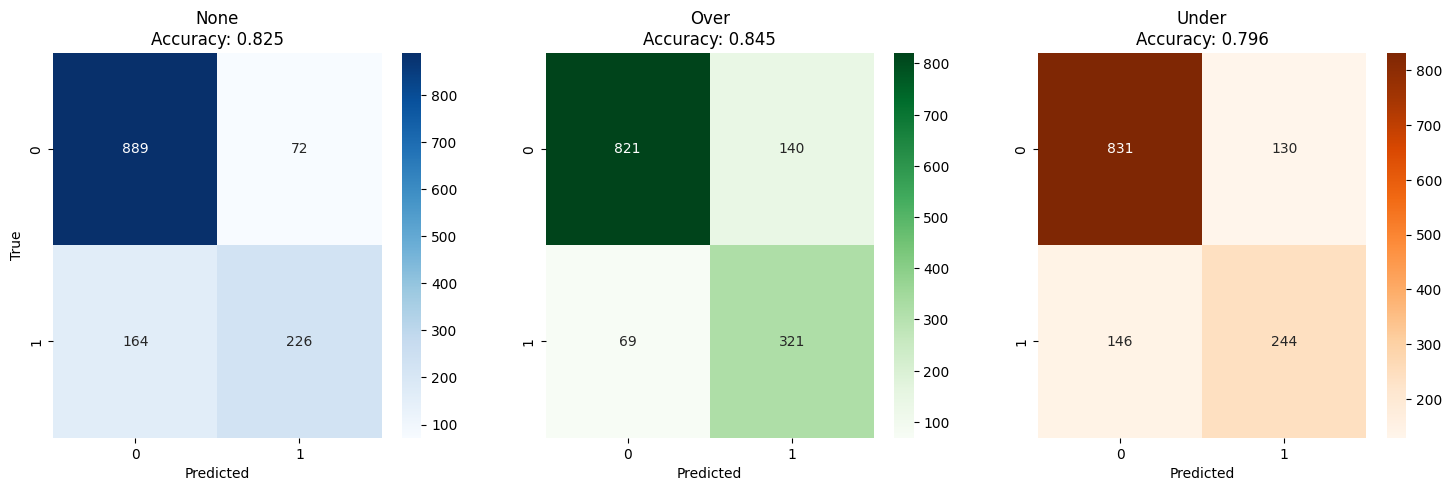

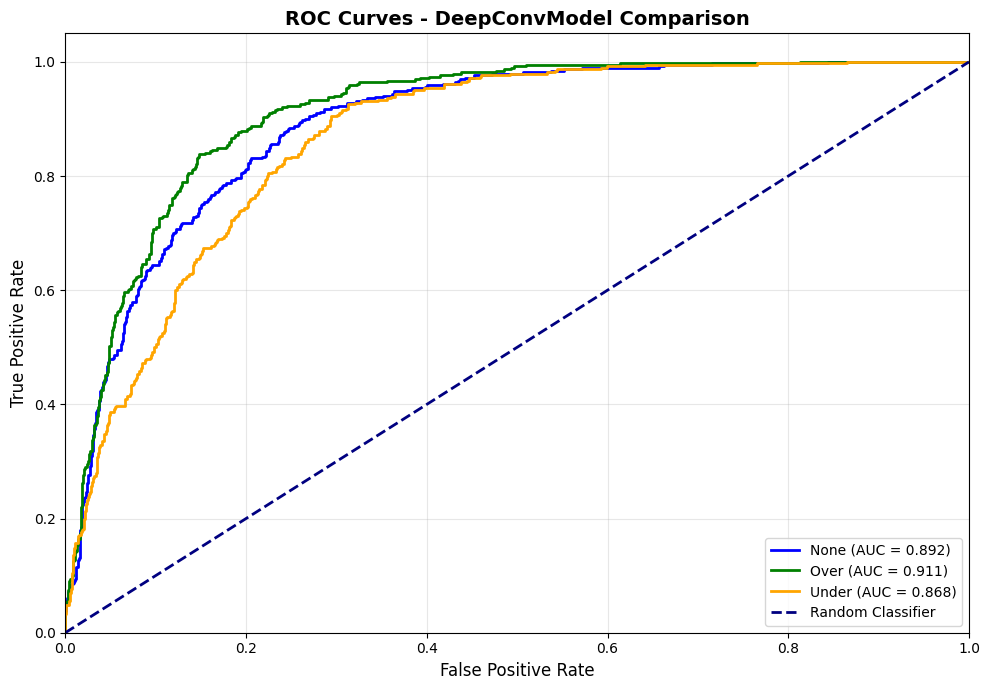

In [ ]:
results = compute_results("DeepConvModel", **configs)
render_plots("DeepConvModel", results, colors)

## 4. Evaluation

In [ ]:
evaluation_results = []

models_to_evaluate = [
    "DecisionTree", "NaiveBayes", "KNN", "SVC", "MLP", 
    "RandomForest", "AdaBoost", "XGBoost", "CustomEnsemble", "DeepConvModel", "SVC_PCA", "SVC_UMAP"
]

for model_name in models_to_evaluate:
    print(f"Training {model_name}")
    results = compute_results(model_name, **configs)
    
    for strategy in results.keys():
        evaluation_results.append({
            "Model": model_name,
            "Strategy": strategy,
            "Accuracy": results[strategy]["accuracy"],
            "Precision": results[strategy]["Precision"],
            "Recall": results[strategy]["Recall"],
            "F1": results[strategy]["F1"],
            "ROC-AUC": results[strategy]["ROC-AUC"]
        })

#  DataFrame sorted by ROC-AUC
evaluation_df = pd.DataFrame(evaluation_results).sort_values(
    ["F1", "ROC-AUC"], ascending=[False, False]
)
evaluation_df.to_csv("data/model_evaluation_summary.csv", index=False)

Training DecisionTree


NameError: name 'compute_results' is not defined

In [ ]:
# visualize the evaluation dataframe
evaluation_df

Model Strategy  Accuracy  Precision    Recall        F1   ROC-AUC
16    RandomForest     over  0.893412   0.758403  0.925641  0.833718  0.963786
15    RandomForest     none  0.914138   0.856771  0.843590  0.850129  0.962743
22         XGBoost     over  0.903775   0.787611  0.912821  0.845606  0.961920
21         XGBoost     none  0.908956   0.829630  0.861538  0.845283  0.960314
25  CustomEnsemble     over  0.891932   0.752066  0.933333  0.832952  0.958246
24  CustomEnsemble     none  0.912657   0.846939  0.851282  0.849105  0.954863
17    RandomForest    under  0.868986   0.704415  0.941026  0.805708  0.952149
23         XGBoost    under  0.867506   0.705653  0.928205  0.801772  0.947998
26  CustomEnsemble    under  0.866025   0.702128  0.930769  0.800441  0.942522
9              SVC     none  0.871947   0.784777  0.766667  0.775616  0.932362
10             SVC     over  0.826795   0.634021  0.946154  0.759259  0.928709
8              KNN    under  0.856403   0.696787  0.889744  0.781532  0.926127
6              KNN     none  0.883790   0.814016  0.774359  0.793693  0.924250
28   DeepConvModel     over  0.859363   0.736967  0.797436  0.766010  0.923699
13             MLP     over  0.793486   0.590835  0.925641  0.721279  0.922682
12             MLP     none  0.854182   0.739454  0.764103  0.751576  0.920006
11             SVC    under  0.830496   0.645045  0.917949  0.757672  0.918290
27   DeepConvModel     none  0.840118   0.755882  0.658974  0.704110  0.912839
7              KNN     over  0.891192   0.827493  0.787179  0.806833  0.906901
29   DeepConvModel    under  0.826055   0.678161  0.756410  0.715152  0.898938
14             MLP    under  0.807550   0.612457  0.907692  0.731405  0.897124
34        SVC_UMAP     over  0.840118   0.655914  0.938462  0.772152  0.891094
35        SVC_UMAP    under  0.834937   0.659048  0.887179  0.756284  0.875594
18        AdaBoost     none  0.805329   0.665796  0.653846  0.659767  0.873020
20        AdaBoost    under  0.783864   0.589091  0.830769  0.689362  0.872980
19        AdaBoost     over  0.758697   0.551780  0.874359  0.676587  0.869688
1     DecisionTree     over  0.849741   0.708241  0.815385  0.758045  0.839957
30         SVC_PCA     none  0.803109   0.649038  0.692308  0.669975  0.835577
0     DecisionTree     none  0.862324   0.769841  0.746154  0.757812  0.827812
33        SVC_UMAP     none  0.875648   0.792105  0.771795  0.781818  0.825572
2     DecisionTree    under  0.817172   0.643287  0.823077  0.722160  0.821499
3       NaiveBayes     none  0.772021   0.585062  0.723077  0.646789  0.820043
5       NaiveBayes    under  0.690600   0.478979  0.817949  0.604167  0.819814
32         SVC_PCA    under  0.760918   0.562617  0.771795  0.650811  0.815713
4       NaiveBayes     over  0.661732   0.453278  0.833333  0.587173  0.814075
31         SVC_PCA     over  0.725389   0.515347  0.817949  0.632309  0.812799

In [ ]:
accuracy_pivot = evaluation_df.pivot(index="Model", columns="Strategy", values="Accuracy")
print(accuracy_pivot.round(4).to_string())

Strategy          none    over   under
Model                                 
AdaBoost        0.8053  0.7587  0.7839
CustomEnsemble  0.9127  0.8919  0.8660
DecisionTree    0.8623  0.8497  0.8172
DeepConvModel   0.8401  0.8594  0.8261
KNN             0.8838  0.8912  0.8564
MLP             0.8542  0.7935  0.8075
NaiveBayes      0.7720  0.6617  0.6906
RandomForest    0.9141  0.8934  0.8690
SVC             0.8719  0.8268  0.8305
SVC_PCA         0.8031  0.7254  0.7609
SVC_UMAP        0.8756  0.8401  0.8349
XGBoost         0.9090  0.9038  0.8675


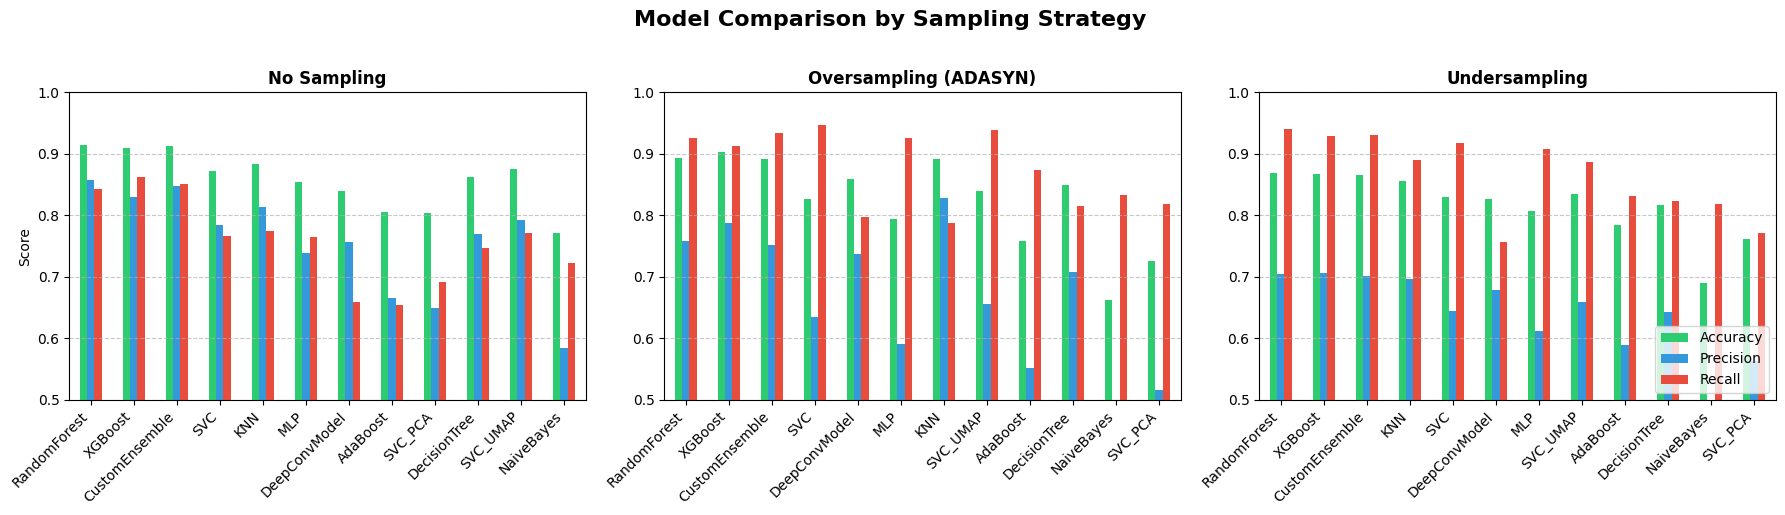

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Comparison by Sampling Strategy', fontsize=16, fontweight='bold', y=1.02)

strategies = ['none', 'over', 'under']
strategy_titles = {'none': 'No Sampling', 'over': 'Oversampling (ADASYN)', 'under': 'Undersampling'}

for idx, strategy in enumerate(strategies):
    ax = axes[idx]
    
    # Filtra per strategia
    df_strategy = evaluation_df[evaluation_df["Strategy"] == strategy].copy()
    df_strategy = df_strategy.set_index("Model")[["Accuracy", "Precision", "Recall"]]
    
    # Plot senza legenda automatica
    df_strategy.plot.bar(ax=ax, color=['#2ecc71', '#3498db', '#e74c3c'], legend=False)
    
    ax.set_title(strategy_titles[strategy], fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Score' if idx == 0 else '')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.5, 1.0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Legenda solo nell'ultimo plot
    if idx == 2:
        ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### 1. La strategia "None" (senza sampling) performa meglio
Contrariamente alle aspettative, quasi tutti i modelli ottengono le migliori performance senza sampling. Questo suggerisce che:
- Lo sbilanciamento delle classi non è così critico per questo dataset
- I modelli riescono a gestire bene il leggero sbilanciamento naturale

#### 2. Oversampling (ADASYN) peggiora alcuni modelli
Modelli che peggiorano significativamente con oversampling:
- **NaiveBayes**: 0.772 → 0.662 (-11%)
- **MLP**: 0.854 → 0.794 (-6%)
- **AdaBoost**: 0.805 → 0.759 (-5%)
- **SVC_PCA**: 0.803 → 0.725 (-8%)

#### 3. Ensemble e Tree-based dominano
RandomForest, CustomEnsemble e XGBoost sono consistentemente i migliori, robusti a tutte le strategie di sampling.

#### 4. Riduzione dimensionale (PCA vs UMAP)
- **SVC_PCA** (0.803) performa peggio di **SVC** (0.872) - perdita del ~7%
- **SVC_UMAP** (0.876) recupera quasi tutta la performance, confermando che UMAP preserva meglio la struttura dei dati rispetto a PCA

#### 5. NaiveBayes è il modello peggiore
Performance bassa (0.66-0.77) in tutte le strategie, probabilmente perché le feature non sono indipendenti come richiesto dall'assunzione del modello.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'f1', 'roc_auc']

cv_results = []
models_for_cv = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-validation per ogni strategia di sampling
strategies_data = {
    'none': (X_train, y_train),
    'over': (X_train_over, y_train_over),
    'under': (X_train_under, y_train_under)
}

for strategy, (X_tr, y_tr) in strategies_data.items():
   
    print(f"Cross-Validation with {strategy.upper()} sampling")
    
    
    for name, model in models_for_cv.items():
        print(f'Training and validating {name}')
        
        
        model_copy = clone(model) # Crea una copia del modello e applica gli iperparametri della strategia corrente
        if name in hyperparameters.get(strategy, {}):
            model_copy.set_params(**hyperparameters[strategy][name]["params"])
        
        scores = cross_validate(model_copy, X_tr, y_tr, cv=cv, scoring=scoring)
        
        cv_results.append({
            'Model': name,
            'Strategy': strategy,
            'Accuracy (mean)': scores['test_accuracy'].mean(),
            'Accuracy (std)': scores['test_accuracy'].std(),
            'F1 (mean)': scores['test_f1'].mean(),
            'F1 (std)': scores['test_f1'].std(),
            'ROC-AUC (mean)': scores['test_roc_auc'].mean(),
            'ROC-AUC (std)': scores['test_roc_auc'].std()
        })

cv_df = pd.DataFrame(cv_results)
cv_df.to_csv("data/cross_validation_results.csv", index=False)

Cross-Validation with NONE sampling
Training and validating DecisionTree
Training and validating NaiveBayes
Training and validating KNN
Training and validating SVC
Training and validating MLP
Training and validating RandomForest
Training and validating AdaBoost
Training and validating XGBoost
Cross-Validation with OVER sampling
Training and validating DecisionTree
Training and validating NaiveBayes
Training and validating KNN
Training and validating SVC
Training and validating MLP
Training and validating RandomForest
Training and validating AdaBoost
Training and validating XGBoost
Cross-Validation with UNDER sampling
Training and validating DecisionTree
Training and validating NaiveBayes
Training and validating KNN
Training and validating SVC
Training and validating MLP
Training and validating RandomForest
Training and validating AdaBoost
Training and validating XGBoost


In [ ]:
cv_df

Model Strategy  Accuracy (mean)  Accuracy (std)  F1 (mean)  \
0   DecisionTree     none         0.855169        0.008313   0.753535   
1     NaiveBayes     none         0.757713        0.025248   0.639159   
2            KNN     none         0.875156        0.003711   0.782423   
3            SVC     none         0.863561        0.009663   0.759739   
4            MLP     none         0.835181        0.011931   0.719174   
5   RandomForest     none         0.898101        0.019611   0.823148   
6       AdaBoost     none         0.808043        0.018048   0.670923   
7        XGBoost     none         0.897608        0.015564   0.822957   
8   DecisionTree     over         0.885678        0.004837   0.889675   
9     NaiveBayes     over         0.712052        0.013929   0.741877   
10           KNN     over         0.926939        0.007857   0.928398   
11           SVC     over         0.860580        0.006881   0.873398   
12           MLP     over         0.818807        0.005806   0.833771   
13  RandomForest     over         0.920921        0.005767   0.925507   
14      AdaBoost     over         0.782707        0.007069   0.800785   
15       XGBoost     over         0.921436        0.006374   0.924981   
16  DecisionTree    under         0.818568        0.008679   0.819236   
17    NaiveBayes    under         0.742054        0.016833   0.762900   
18           KNN    under         0.844068        0.015123   0.848453   
19           SVC    under         0.849086        0.012696   0.856293   
20           MLP    under         0.828174        0.015634   0.838434   
21  RandomForest    under         0.871238        0.017465   0.875093   
22      AdaBoost    under         0.808954        0.020539   0.816761   
23       XGBoost    under         0.866217        0.013453   0.867982   

    F1 (std)  ROC-AUC (mean)  ROC-AUC (std)  
0   0.015699        0.824837       0.012205  
1   0.038431        0.817022       0.024170  
2   0.010696        0.909379       0.012727  
3   0.018409        0.920656       0.011046  
4   0.018840        0.906170       0.012057  
5   0.036273        0.956248       0.010953  
6   0.030513        0.882557       0.016320  
7   0.029376        0.953155       0.008353  
8   0.004186        0.886544       0.007076  
9   0.011534        0.784492       0.008315  
10  0.007425        0.950916       0.006228  
11  0.005795        0.929631       0.002356  
12  0.004714        0.888952       0.005365  
13  0.005230        0.975044       0.001749  
14  0.007042        0.853988       0.005332  
15  0.006235        0.970930       0.001287  
16  0.009352        0.820733       0.009887  
17  0.012650        0.825028       0.020944  
18  0.012735        0.910368       0.014805  
19  0.010522        0.915607       0.008796  
20  0.011893        0.884315       0.020116  
21  0.016199        0.942653       0.014836  
22  0.016936        0.881699       0.021359  
23  0.013998        0.936118       0.014636

In [ ]:
accuracy_pivot = cv_df.pivot(index="Model", columns="Strategy", values="Accuracy (mean)")
print(accuracy_pivot.round(4).to_string())

Strategy        none    over   under
Model                               
AdaBoost      0.8080  0.7827  0.8090
DecisionTree  0.8552  0.8857  0.8186
KNN           0.8752  0.9269  0.8441
MLP           0.8352  0.8188  0.8282
NaiveBayes    0.7577  0.7121  0.7421
RandomForest  0.8981  0.9209  0.8712
SVC           0.8636  0.8606  0.8491
XGBoost       0.8976  0.9214  0.8662


             Strategy  Accuracy (mean)  Accuracy (std)  F1 (mean)  F1 (std)  \
Model                                                                         
KNN              over            0.927           0.008      0.928     0.007   
RandomForest     over            0.921           0.006      0.926     0.005   
XGBoost          over            0.921           0.006      0.925     0.006   
XGBoost          none            0.898           0.016      0.823     0.029   
RandomForest     none            0.898           0.020      0.823     0.036   
DecisionTree     over            0.886           0.005      0.890     0.004   
KNN              none            0.875           0.004      0.782     0.011   
RandomForest    under            0.871           0.017      0.875     0.016   
XGBoost         under            0.866           0.013      0.868     0.014   
SVC              none            0.864           0.010      0.760     0.018   
SVC              over            0.861           0.0

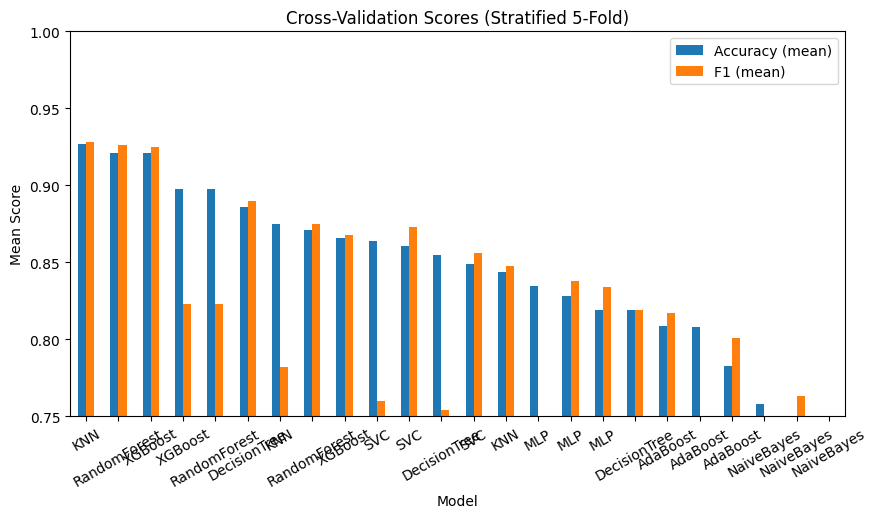

In [ ]:
df_cv = pd.DataFrame(cv_results).set_index('Model').round(3).sort_values("Accuracy (mean)", ascending=False)

print(df_cv)
df_cv[['Accuracy (mean)', 'F1 (mean)']].plot(kind='bar', figsize=(10,5))
plt.title("Cross-Validation Scores (Stratified 5-Fold)")
plt.ylabel("Mean Score")
plt.ylim(0.75, 1)
plt.xticks(rotation=30)
plt.show()


#### 1. Oversampling (ADASYN) migliora significativamente alcuni modelli
Contrariamente ai risultati sul test set, in cross-validation l'oversampling mostra miglioramenti:
- **KNN**: 0.875 → 0.927 (+5.2%)
- **RandomForest**: 0.898 → 0.921 (+2.3%)
- **XGBoost**: 0.898 → 0.921 (+2.3%)
- **DecisionTree**: 0.855 → 0.886 (+3.1%)

#### 2. Top 3 Modelli (con Oversampling)
1. **KNN** - 0.927
2. **XGBoost** - 0.921
3. **RandomForest** - 0.921

#### 3. Modelli che non beneficiano dell'oversampling
- **NaiveBayes**: 0.758 → 0.712 (-4.6%)
- **MLP**: 0.835 → 0.819 (-1.6%)
- **AdaBoost**: 0.808 → 0.783 (-2.5%)

#### 4. Undersampling performa peggio
Tutti i modelli mostrano performance inferiori con undersampling rispetto alle altre strategie, probabilmente per la perdita di informazione.

La cross-validation suggerisce che **oversampling con ADASYN** è buono per modelli tree-based (RandomForest, XGBoost, DecisionTree) e KNN, mentre modelli come NaiveBayes e MLP migliorano con i dati originali senza sampling.

## 5. Result Discussion